In [1]:
# Standard libraries
import re
import subprocess
import time
import warnings

# Data handling and numerical libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical and machine learning libraries
from scipy.stats import entropy, pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Bioinformatics libraries from Biopython
from Bio import SeqIO, AlignIO, motifs
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils.ProtParam import ProteinAnalysis, ProtParamData
from Bio.Align import MultipleSeqAlignment, AlignInfo
from Bio.motifs import create
from Bio import BiopythonDeprecationWarning

# Progress bar
from tqdm import tqdm

# Suppress specific Biopython deprecation warnings
warnings.filterwarnings('ignore', category=BiopythonDeprecationWarning)


In [2]:
# Suppress Biopython deprecation warnings
warnings.filterwarnings('ignore', category=BiopythonDeprecationWarning)


In [3]:
# Load the dataset
lysin_df = pd.read_json('lysin_unnested_data.json')

# Drop columns from lysin_df
lysin_df.drop(columns=['Start', 'Stop', 'Orientation', 'Accession', 'phams', 'PhageID'], inplace=True)

lysin_df.fillna("Unknown", inplace=True)

In [4]:
lysin_df.head()

GeneID  Length  Name  \
0  20ES_CDS_10     978  20ES   
1   20ES_CDS_8    1299  20ES   
2   244_CDS_34    1503   244   
3  32HC_CDS_36    1368  32HC   
4  32HC_CDS_37    1152  32HC   

                                         translation       Notes  \
0  MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...  b'lysin B'   
1  MTAVITRKQAQWVHDMARARNGLPYAYGGAFTNDPKRSTDCSGLVL...  b'lysin A'   
2  MSVTRANVEATKRFIGERVGNPYVYGGALSPTNVHQGTDCSEVWQT...  b'lysin A'   
3  MPGSEIPRYWPLGAGRIVTSPFGPRSGGFHAGVDFGRNGGSAGMPV...  b'lysin A'   
4  MAWKQPQLTDPPMVSEEIGKLNRRLLLAYAANSRAVEAGVQLHDVF...  b'lysin B'   

      HostStrain Cluster  
0  Mycobacterium      A2  
1  Mycobacterium      A2  
2  Mycobacterium       E  
3  Mycobacterium       Z  
4  Mycobacterium       Z

In [5]:
# Define the search patterns for each lysin type
lysin_A_patterns = [
    'lysin A', 'putative lysin A', 'lysin A, protease M23 domain',
    'lysin A, N-acetylmuramoyl-L-alanine amidase domain', 'lysin A, L-Ala-D-Glu peptidase domain',
    'lysin A, glycosyl hydrolase domain', 'lysin A, protease C39 domain',
    'lysin A, N-acetylmuramoyl-L-alanine amidase', 'lysin A, M23 peptidase domain',
    'lysin A, amidase domain', 'lysin A, L-ala D-glu peptidase domain',
    'lysin A glycosidase domain', 'lysin A amidase domain', 'lysin A peptidase domain',
    'lysin A, N-acetylmuramoyl-L-alanine amides domain', 'lysin A, protease M15 domain',
    'lysin A N-acetylmuramoyl-L-alanine amidase domain', 'lysin A L-Ala-D-Glu peptidase domain',
    'lysin A, protease domain', 'lysin A, N-acetyl-B-D-muramidase domain',
    'lysin A glycosyl hydrolase domain', 'lysin A, GH19 glycoside hydrolase domain',
    'lysin A, N-acetyl-beta-D-muramidase domain', 'lysin A, peptidase domain',
    'lysinA, hydrolase domain', 'Lysin A', 'lysin A, N-acetylmuramoyl-Lalanine amidase domain',
    'lysin A, l-ala-d-glu peptidase domain', 'lysin A, C39 peptidase domain',
    'lysin A, glycosyl hyrdrolase domain', 'lysin A, L-Ala,-D-Glu peptidase domain',
    'lysin A, M15 protease', 'lysin A, protease C39', 'putitive lysin A'
]

lysin_B_patterns = [
    'lysin B', 'putative lysin B', 'lysinB protein', 'putitive lysin B'
]

endolysin_patterns = [
    'endolysin', 'LysM-like endolysin', 'endolysin, L-Ala-D-Glu peptidase domain',
    'endolysin, N-acetylmuramoyl-L-alanine amidase domain', 'endolysin, protease M23 domain',
    'endolysin, protease C39 domain', 'endolysin, glycosyl hydrolase domain',
    'endolysin domain protein', 'endolysin, protease M15 domain', 'endolysin amidase',
    'endolysin endopeptidase/amidase', 'putative endolysin', 'endolysin, protease M23 domain and cell wall binding domain',
    'endolysin, protease domain'
]

# Combine all patterns into regex patterns
lysin_A_pattern = '|'.join(lysin_A_patterns)
lysin_B_pattern = '|'.join(lysin_B_patterns)
endolysin_pattern = '|'.join(endolysin_patterns)

# Define a function to determine the LysinType
def determine_lysin_type(notes):
    if re.search(lysin_A_pattern, notes, re.IGNORECASE):
        return 'lysin A'
    elif re.search(lysin_B_pattern, notes, re.IGNORECASE):
        return 'lysin B'
    elif re.search(endolysin_pattern, notes, re.IGNORECASE):
        return 'endolysin'
    else:
        return 'unknown'

# Apply the function to create a new column LysinType
lysin_df['LysinType'] = lysin_df['Notes'].apply(determine_lysin_type)

In [6]:
lysin_df.head()

GeneID  Length  Name  \
0  20ES_CDS_10     978  20ES   
1   20ES_CDS_8    1299  20ES   
2   244_CDS_34    1503   244   
3  32HC_CDS_36    1368  32HC   
4  32HC_CDS_37    1152  32HC   

                                         translation       Notes  \
0  MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...  b'lysin B'   
1  MTAVITRKQAQWVHDMARARNGLPYAYGGAFTNDPKRSTDCSGLVL...  b'lysin A'   
2  MSVTRANVEATKRFIGERVGNPYVYGGALSPTNVHQGTDCSEVWQT...  b'lysin A'   
3  MPGSEIPRYWPLGAGRIVTSPFGPRSGGFHAGVDFGRNGGSAGMPV...  b'lysin A'   
4  MAWKQPQLTDPPMVSEEIGKLNRRLLLAYAANSRAVEAGVQLHDVF...  b'lysin B'   

      HostStrain Cluster LysinType  
0  Mycobacterium      A2   lysin B  
1  Mycobacterium      A2   lysin A  
2  Mycobacterium       E   lysin A  
3  Mycobacterium       Z   lysin A  
4  Mycobacterium       Z   lysin B

In [7]:
unknown_lysin_types = lysin_df[lysin_df['LysinType'] == 'unknown']
unknown_lysin_types

GeneID  Length          Name  \
21    AbbeyMikolon_CDS_21     834  AbbeyMikolon   
363           ArV1_CDS_26    1653          ArV1   
406        Attacne_CDS_20     855       Attacne   
677          BFK20_CDS_24     813         BFK20   
957    BruceLethal_CDS_20     861   BruceLethal   
1295       Chymera_CDS_20     876       Chymera   
1989         Enoki_CDS_20     864         Enoki   
2316          GAL1_CDS_22    1101          GAL1   
2453          GMA1_CDS_20    1056          GMA1   
2454          GMA2_CDS_36     729          GMA2   
2455          GMA2_CDS_37     372          GMA2   
2456          GMA2_CDS_38     669          GMA2   
2457          GMA3_CDS_22     702          GMA3   
2458          GMA3_CDS_26     348          GMA3   
2459          GMA4_CDS_21    1074          GMA4   
2460           GMA5_CDS_5     789          GMA5   
2461          GMA6_CDS_34     798          GMA6   
2462          GMA6_CDS_45    3264          GMA6   
2463          GMA7_CDS_41     900          GMA7   
2464        Gmala1_CDS_22     702        Gmala1   
2496      GordDuk1_CDS_22     702      GordDuk1   
2500      GordTnk2_CDS_22     702      GordTnk2   
2555           GRU3_CDS_5     789          GRU3   
2566          GTE2_CDS_18     546          GTE2   
2567          GTE6_CDS_38    1635          GTE6   
2569          GTE8_CDS_36     633          GTE8   
2570          GTE8_CDS_37    1023          GTE8   
3300         Keiki_CDS_20     855         Keiki   
3449         Kubed_CDS_20     861         Kubed   
3533     Lauchelly_CDS_20     855     Lauchelly   
4295       Moyashi_CDS_20     864       Moyashi   
4305          MrAK_CDS_20     864          MrAK   
4470       Nesbitt_CDS_21     855       Nesbitt   
4742     Ouroboros_CDS_20     855     Ouroboros   
4771         P1201_CDS_52    1509         P1201   
5267     Procrass1_CDS_20     858     Procrass1   
5453          REQ1_CDS_63    1077          REQ1   
5454          REQ1_CDS_83    1089          REQ1   
5455          REQ2_CDS_22     711          REQ2   
5456          REQ3_CDS_52     753          REQ3   
5467          RGL3_CDS_66    1314          RGL3   
5575          Rowa_CDS_21     855          Rowa   
5584           RRH1_CDS_5     735          RRH1   
5965          SKKY_CDS_20     858          SKKY   
6026         Solid_CDS_20     858         Solid   
6191     Stormborn_CDS_20     855     Stormborn   
6559          TPA2_CDS_55    1608          TPA2   
6560          TPA4_CDS_31    1113          TPA4   
6957         Wizzo_CDS_20     855         Wizzo   

                                            translation              Notes  \
21    MSNASKIVSVAKGEVGYREGKSGSHYNNKQKYSGQVPGLEWSNYQP...           b'lysin'   
363   MTTALQERFLNGAAGNYYDPDGVYAFQCVDTAIAYAMACYPEVNWE...           b'lysin'   
406   MRYIPAAHHSAGSNSPVNRVVIHATCPDVGFPSASRKGRAVSTANY...           b'lysin'   
677   MVPKVRDWTARFLFGGPRSTSKLIGVCIHTTENDPSTPAENVANYQ...     b'gp24, lysin'   
957   MRYIPAAHHSAGSNHPVNRVVIHATCPDVGFPSASRAGRAVSTANY...           b'lysin'   
1295  MATPLTPDRLLAALRAEGVTVVEHPGWRTHNRNHMGPFGPVHGVMI...           b'lysin'   
1989  MRYIPAAHHSAGSNKPVNRVVIHATCPDVGFPSASRKGRAVSTANY...           b'lysin'   
2316  MADPVWLPDVLRAEGLRCDIYPGAFERGHGDFGTIWGPFMHHTGSF...  b'putative lysin'   
2453  MGKPKFRDIERLGPSQSPRHGARVVFALGHTQEGNGTAESLAAYLN...  b'putative lysin'   
2454  MTVHKDLTGISIPKGGTSGMWNAANTIKQVIVIHDTESGNAAGALN...  b'putative lysin'   
2455  MSDASDVVANSKQLGVSSTWGKSPRQLANEYNPDAKSQWARPAIEK...  b'putative lysin'   
2456  MIEIAGSPRKFGRKVEHDPRSRAYGVAVNPAEEPVSILWTNRAPVL...  b'putative lysin'   
2457  MTRTLIDSGARIEAAGIKRAGHVGSFGYLSTSRPGTFFSGKPIRQD...  b'putative lysin'   
2458  MPSAADDVNTQFMGDKDKNGKWGWTGLAPQPDNNDVRYSQFVKKVV...  b'putative lysin'   
2459  MTWRGDPTWLADVLRAEGLKVIEEPGWKQRGHGDFLDIRGIIWHHT...  b'putative lysin'   
2460  MTFRTVYGNTYSENGWRMCNADETVVVRVADMPLRVRGGYAAEALG...  b'putative lysin'   
2461  MPSVQIIVPKYDSKSGRPKMILMGSNGDMFSVPWAPRSVQHSNLGE...  b'putative lysin'   
2462  MADRVGIDFSANEIDPAAIKAAGVEAVINYISEARPSAPWMKAVKP...  b'putat

In [8]:
# Drop rows with LysinType 'Unknown'
lysin_df = lysin_df[lysin_df['LysinType'] != 'unknown']

In [9]:
# Check for missing values in each column
missing_values = lysin_df.isnull().sum()
missing_values

GeneID         0
Length         0
Name           0
translation    0
Notes          0
HostStrain     0
Cluster        0
LysinType      0
dtype: int64

In [10]:
# Unique value counts for each object-type column
for column in lysin_df.select_dtypes(include='object').columns:
    print(f"Counts of unique values in column '{column}':")
    print(lysin_df[column].value_counts())
    print("\n")

Counts of unique values in column 'GeneID':
GeneID
20ES_CDS_10          1
Paedore_CDS_26       1
Paola_CDS_28         1
Panchino_CDS_25      1
Panamaxus_CDS_9      1
                    ..
Geraldini_CDS_29     1
Geostin_CDS_2        1
Georgie2_CDS_9       1
Georgie2_CDS_11      1
ZygoTaiga_CDS_216    1
Name: count, Length: 7133, dtype: int64


Counts of unique values in column 'Name':
Name
Jumbo            4
Gorko            4
Skog             4
Bipper           4
Malisha          3
                ..
ClearAsMud       1
PrincePhergus    1
Goby             1
Priamo           1
Phriends         1
Name: count, Length: 4182, dtype: int64


Counts of unique values in column 'translation':
translation
MTQPTAWQPPQNVGDVAVTVAQAKAKLKVFSYGAAFKTETSNVYTAEFGTALRTFQQRRNAEIHEGKKPGPVMNTDGVLDWATKKQLGILPEQTAPAPPPVPANRAAALVFRGTGGIIGQDYVSQVCQQVGPMVEEINPEFPASMGGLPPGAPNLPSARQAIDIGYRSGAAWIKANPSRKFVLGGYSLGEIVVAKLLTALFSPGGELAAFRDNYVCSFHIGPPARPLGGAFYGGTAAPGVGIASNRLATDIYAQLGPRACYLCDPEDMYGSIPVPVEGGTGDIMETVYDMVTTLA

In [11]:
# Get counts of each LysinType
lysin_type_counts = lysin_df['LysinType'].value_counts()
lysin_type_counts

LysinType
lysin A      3458
lysin B      2528
endolysin    1147
Name: count, dtype: int64

In [12]:
# Filter the dataframe by LysinType
lysin_a_df = lysin_df[lysin_df['LysinType'] == 'lysin A']
lysin_b_df = lysin_df[lysin_df['LysinType'] == 'lysin B']
endolysin_df = lysin_df[lysin_df['LysinType'] == 'endolysin']

In [13]:
# Function to perform MSA and calculate consensus sequences
def perform_msa(dataframe, output_prefix):
    sequences = [SeqRecord(Seq(row['translation']), id=row['GeneID']) for index, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0], desc='Creating SeqRecord objects')]
    fasta_file = f"{output_prefix}_lysins.fasta"
    SeqIO.write(sequences, fasta_file, "fasta")
    print(f"Sequences written to {fasta_file}")

    aligned_file = f"aligned_{output_prefix}_lysins.fasta"
    clustal_omega_command = ["clustalo", "-i", fasta_file, "-o", aligned_file, "--force"]
    print(f"Running Clustal Omega for multiple sequence alignment on {output_prefix}...")
    subprocess.run(clustal_omega_command)
    print(f"Multiple sequence alignment completed and saved to {aligned_file}")

    alignment = AlignIO.read(aligned_file, "fasta")
    print(f"Alignment read from {aligned_file}")
    return alignment

# Perform MSA for each dataframe
alignment_lysin_a = perform_msa(lysin_a_df, "lysin_a")
alignment_lysin_b = perform_msa(lysin_b_df, "lysin_b")
alignment_endolysin = perform_msa(endolysin_df, "endolysin")

Creating SeqRecord objects: 100%|████████████████████████████████████████████████| 3458/3458 [00:00<00:00, 6838.98it/s]


Sequences written to lysin_a_lysins.fasta
Running Clustal Omega for multiple sequence alignment on lysin_a...
Multiple sequence alignment completed and saved to aligned_lysin_a_lysins.fasta
Alignment read from aligned_lysin_a_lysins.fasta


Creating SeqRecord objects: 100%|████████████████████████████████████████████████| 2528/2528 [00:00<00:00, 8445.07it/s]


Sequences written to lysin_b_lysins.fasta
Running Clustal Omega for multiple sequence alignment on lysin_b...
Multiple sequence alignment completed and saved to aligned_lysin_b_lysins.fasta
Alignment read from aligned_lysin_b_lysins.fasta


Creating SeqRecord objects: 100%|████████████████████████████████████████████████| 1147/1147 [00:00<00:00, 7883.51it/s]


Sequences written to endolysin_lysins.fasta
Running Clustal Omega for multiple sequence alignment on endolysin...
Multiple sequence alignment completed and saved to aligned_endolysin_lysins.fasta
Alignment read from aligned_endolysin_lysins.fasta


In [14]:
# Function to calculate and print consensus sequence for a given alignment
def print_consensus(alignment, alignment_name):
    # Create a summary info object from the alignment
    summary_align = AlignInfo.SummaryInfo(alignment)

    # Generate the consensus sequence
    consensus = summary_align.dumb_consensus()

    # Print the consensus sequence
    print(f"Consensus Sequence for {alignment_name}:")
    print(consensus)
    print("\n")  # For better readability between consensus outputs

# Print consensus for each alignment
print_consensus(alignment_lysin_a, "Lysin A")
print_consensus(alignment_lysin_b, "Lysin B")
print_consensus(alignment_endolysin, "Endolysin")

Consensus Sequence for Lysin A:
MTTPNVPTGNVTPPGPQPGTGYSQTTPDQEQGVDNYYLTDVGGKEPPPMETLVYTPRVRIIISRDXXXYXXXXXVVAXPVNRVENSVSSAAFRLINKPEDQYDENHRMTDXNXLLXPEDRVAIFMKRSEWVQVFSGYLDSVNLADYFNENXXFXXXXRKKSSLTQRFNDGIXXXXMSFXXXXTLSQXXXXPLXXXXXLXTMLSVXSNPDRTDTGYSDDMXAXLGXLMXXXTXDXXAXXXXXEGRRSRSGEGQXXXXXXXRXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXAXXXXXXXXXGXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXVVPPLLDAQXXALXXPXXXXXMXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXAXXXXXXXXXXXXXGVTGSAXXXXXXXXXXXQQXXXXXXXGGXXXXSGVXXXXXXXXGXXXXXXXXWXGXXXXXXDXXXXXXXXXXXXXXXXXXXXXXXXGGXXXXPXXXXXXXXXXXXXXXVIDGGIAVDLXXXXXXKXTXEXXXXXXXGXXDXXXVXXXXXPGXXXXXXXXXXRXXXGXXXXXNGWXMXXXXXDECXXXXXXMXXXXXXPRXXFXXXLXSXLXXRXXXXXXXXXXXXXXXDXGQXXXXXXXXXXXXXXXXXXPSAXXXXXXXXCXXAXXXXXXXRXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXPXTXXAXXHEXXXXEKNGXXXXXXXXXGXXXXXXXXVAXXXXXGXXPXXXPAKXXGXXXXXXXXXXXXXXXRXXXXXXXXXXXXXSGAXXXXXXGXXGXXXXXGXXXXXXAKANXXXTIXXXXGXXXXXDXXXXXEXXXXXXXXXXXXXXXXXXXTXXXXXVGXAXXXGIXXXSNHXXGTAXXXXXDXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXTXXXXXXXXXXXXXX

In [15]:
def hamming_distance(seq1, seq2):
    """Calculate Hamming distance between two sequences, ignoring gaps."""
    return sum(a != b for a, b in zip(seq1, seq2) if a != '-' and b != '-')

def calculate_conservation_score(alignment):
    """Calculate the average conservation score across all positions in the alignment."""
    scores = []
    length = alignment.get_alignment_length()
    for i in tqdm(range(length), desc="Calculating Conservation Scores"):
        column = alignment[:, i]
        most_common = max(set(column), key=column.count)
        score = column.count(most_common) / len(column)
        scores.append(score)
    return np.mean(scores)

def calculate_shannon_entropy(alignment):
    """Calculate the average Shannon entropy across all positions in the alignment."""
    scores = []
    length = alignment.get_alignment_length()
    for i in tqdm(range(length), desc="Calculating Shannon Entropy"):
        column = alignment[:, i]
        counts = np.bincount([ord(char) for char in column], minlength=256)
        prob = counts[counts.nonzero()] / len(column)
        scores.append(entropy(prob))
    return np.mean(scores)

def generate_dataframe_from_alignment(alignment, alignment_name):
    """Generate a DataFrame with various sequence metrics from the alignment."""
    print(f"Generating data for {alignment_name}")
    summary_align = AlignInfo.SummaryInfo(alignment)
    consensus = summary_align.dumb_consensus()

    distances_from_consensus = [sum(a != b for a, b in zip(str(record.seq), str(consensus))) / alignment.get_alignment_length() for record in tqdm(alignment, desc="Calculating Distances from Consensus")]
    hamming_distances = [hamming_distance(str(record.seq), str(consensus)) for record in tqdm(alignment, desc="Calculating Hamming Distances")]

    # Only include distances in the DataFrame
    data = {
        "GeneID": [record.id for record in alignment],
        "Distance from Consensus": distances_from_consensus,
        "Hamming Distance": hamming_distances
    }
    df = pd.DataFrame(data)
   
    return df

# Compute and print conservation score and Shannon entropy once for each alignment
conservation_score_lysin_a = calculate_conservation_score(alignment_lysin_a)
shannon_entropy_lysin_a = calculate_shannon_entropy(alignment_lysin_a)
print(f"Conservation Score for Lysin A: {conservation_score_lysin_a}")
print(f"Shannon Entropy for Lysin A: {shannon_entropy_lysin_a}")

conservation_score_lysin_b = calculate_conservation_score(alignment_lysin_b)
shannon_entropy_lysin_b = calculate_shannon_entropy(alignment_lysin_b)
print(f"Conservation Score for Lysin B: {conservation_score_lysin_b}")
print(f"Shannon Entropy for Lysin B: {shannon_entropy_lysin_b}")

conservation_score_endolysin = calculate_conservation_score(alignment_endolysin)
shannon_entropy_endolysin = calculate_shannon_entropy(alignment_endolysin)
print(f"Conservation Score for Endolysin: {conservation_score_endolysin}")
print(f"Shannon Entropy for Endolysin: {shannon_entropy_endolysin}")

# Generate DataFrames for each lysin type
df_lysin_a = generate_dataframe_from_alignment(alignment_lysin_a, "lysin_A")
df_lysin_b = generate_dataframe_from_alignment(alignment_lysin_b, "lysin_B")
df_endolysin = generate_dataframe_from_alignment(alignment_endolysin, "endolysin")

Calculating Shannon Entropy: 100%|█████████████████████████████████████████████████| 2667/2667 [00:35<00:00, 74.60it/s]


Conservation Score for Lysin A: 0.8480267684873688
Shannon Entropy for Lysin A: 0.5876857563509771


Calculating Shannon Entropy: 100%|█████████████████████████████████████████████████| 1252/1252 [00:13<00:00, 92.53it/s]


Conservation Score for Lysin B: 0.7895430602175759
Shannon Entropy for Lysin B: 0.6632621756593249


Calculating Shannon Entropy: 100%|████████████████████████████████████████████████| 2892/2892 [00:13<00:00, 212.71it/s]


Conservation Score for Endolysin: 0.8922446070752856
Shannon Entropy for Endolysin: 0.46626373411766936
Generating data for lysin_A


Calculating Hamming Distances: 100%|█████████████████████████████████████████████| 3458/3458 [00:00<00:00, 4214.30it/s]


Generating data for lysin_B


Calculating Hamming Distances: 100%|█████████████████████████████████████████████| 2528/2528 [00:00<00:00, 7296.05it/s]


Generating data for endolysin


Calculating Hamming Distances: 100%|█████████████████████████████████████████████| 1147/1147 [00:00<00:00, 3595.00it/s]


In [16]:
df_lysin_a.head()

GeneID  Distance from Consensus  Hamming Distance
0   20ES_CDS_8                 0.990251               406
1   244_CDS_34                 0.986502               464
2  32HC_CDS_36                 0.988001               423
3  39HC_CDS_40                 0.987627               459
4  40AC_CDS_12                 0.989126               472

In [17]:
df_lysin_b.head()

GeneID  Distance from Consensus  Hamming Distance
0  20ES_CDS_10                 0.961661               277
1  32HC_CDS_37                 0.975240               352
2  39HC_CDS_42                 0.965655               288
3  40AC_CDS_14                 0.961661               277
4  40BC_CDS_42                 0.965655               288

In [18]:
df_endolysin.head()

GeneID  Distance from Consensus  Hamming Distance
0     A3Wally_CDS_151                 0.990318               585
1     A3Wally_CDS_315                 0.995159               236
2       A3Wally_CDS_4                 0.995159               236
3  Aaronocolus_CDS_26                 0.993084               297
4         Abba_CDS_19                 0.998271               215

In [21]:
# Combine lysin type DataFrames into a single DataFrame
combined_metrics_df = pd.concat([df_lysin_a, df_lysin_b, df_endolysin])

# Perform the join
# Ensure that the 'GeneID' is set as index or a column in all DataFrames
combined_df = lysin_df.merge(combined_metrics_df, on='GeneID', how='inner')


In [22]:
combined_df.head()

GeneID  Length  Name  \
0  20ES_CDS_10     978  20ES   
1   20ES_CDS_8    1299  20ES   
2   244_CDS_34    1503   244   
3  32HC_CDS_36    1368  32HC   
4  32HC_CDS_37    1152  32HC   

                                         translation       Notes  \
0  MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...  b'lysin B'   
1  MTAVITRKQAQWVHDMARARNGLPYAYGGAFTNDPKRSTDCSGLVL...  b'lysin A'   
2  MSVTRANVEATKRFIGERVGNPYVYGGALSPTNVHQGTDCSEVWQT...  b'lysin A'   
3  MPGSEIPRYWPLGAGRIVTSPFGPRSGGFHAGVDFGRNGGSAGMPV...  b'lysin A'   
4  MAWKQPQLTDPPMVSEEIGKLNRRLLLAYAANSRAVEAGVQLHDVF...  b'lysin B'   

      HostStrain Cluster LysinType  Distance from Consensus  Hamming Distance  
0  Mycobacterium      A2   lysin B                 0.961661               277  
1  Mycobacterium      A2   lysin A                 0.990251               406  
2  Mycobacterium       E   lysin A                 0.986502               464  
3  Mycobacterium       Z   lysin A                 0.988001               423  
4  Mycobacterium       Z   lysin B                 0.975240               352

In [23]:
# Function to calculate properties
def calculate_properties(seq):
    analyzed_seq = ProteinAnalysis(seq)
    
    # Calculate properties
    molecular_weight = analyzed_seq.molecular_weight()
    aromaticity = analyzed_seq.aromaticity()
    instability_index = analyzed_seq.instability_index()
    gravy = analyzed_seq.gravy()
    isoelectric_point = analyzed_seq.isoelectric_point()
    
    # Aliphatic index calculation
    aliphatic_index = (analyzed_seq.count_amino_acids().get('A', 0) + 
                       2.9 * analyzed_seq.count_amino_acids().get('V', 0) + 
                       3.9 * (analyzed_seq.count_amino_acids().get('I', 0) + analyzed_seq.count_amino_acids().get('L', 0))) / len(seq) * 100
    
    # Hydrophobicity calculation
    kd_scale = ProtParamData.kd
    hydrophobicity_values = [kd_scale[aa] for aa in seq if aa in kd_scale]
    hydrophobicity = np.mean(hydrophobicity_values) if hydrophobicity_values else 0
    
    return {
        'MolecularWeight': molecular_weight,
        'Aromaticity': aromaticity,
        'InstabilityIndex': instability_index,
        'Gravy': gravy,
        'IsoelectricPoint': isoelectric_point,
        'AliphaticIndex': aliphatic_index,
        'Hydrophobicity': hydrophobicity
    }

# Assuming combined_df is your DataFrame and it includes a 'translation' column with protein sequences
# Apply the function to each row in the dataframe
properties_df = combined_df['translation'].apply(calculate_properties).apply(pd.Series)

# Merge the calculated properties back to the original dataframe
combined_df = pd.concat([combined_df, properties_df], axis=1)

# Display the first few rows of the updated dataframe
combined_df.head()

GeneID  Length  Name  \
0  20ES_CDS_10     978  20ES   
1   20ES_CDS_8    1299  20ES   
2   244_CDS_34    1503   244   
3  32HC_CDS_36    1368  32HC   
4  32HC_CDS_37    1152  32HC   

                                         translation       Notes  \
0  MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...  b'lysin B'   
1  MTAVITRKQAQWVHDMARARNGLPYAYGGAFTNDPKRSTDCSGLVL...  b'lysin A'   
2  MSVTRANVEATKRFIGERVGNPYVYGGALSPTNVHQGTDCSEVWQT...  b'lysin A'   
3  MPGSEIPRYWPLGAGRIVTSPFGPRSGGFHAGVDFGRNGGSAGMPV...  b'lysin A'   
4  MAWKQPQLTDPPMVSEEIGKLNRRLLLAYAANSRAVEAGVQLHDVF...  b'lysin B'   

      HostStrain Cluster LysinType  Distance from Consensus  Hamming Distance  \
0  Mycobacterium      A2   lysin B                 0.961661               277   
1  Mycobacterium      A2   lysin A                 0.990251               406   
2  Mycobacterium       E   lysin A                 0.986502               464   
3  Mycobacterium       Z   lysin A                 0.988001               423   
4  Mycobacterium       Z   lysin B                 0.975240               352   

   MolecularWeight  Aromaticity  InstabilityIndex     Gravy  IsoelectricPoint  \
0       36578.3514     0.107692         28.285877 -0.326462          5.823575   
1       47493.7668     0.085648         43.986574 -0.496991          6.033084   
2       54853.4855     0.088000         31.915200 -0.496000          5.275534   
3       49043.3853     0.087912         41.476484 -0.469451          8.209549   
4       41216.7621     0.091384         41.574413  0.020366          6.173590   

   AliphaticIndex  Hydrophobicity  
0       82.584615       -0.326462  
1       70.763889       -0.496991  
2       72.000000       -0.496000  
3       67.142857       -0.469451  
4       89.947781        0.020366

In [24]:
combined_df.dtypes

GeneID                      object
Length                       int64
Name                        object
translation                 object
Notes                       object
HostStrain                  object
Cluster                     object
LysinType                   object
Distance from Consensus    float64
Hamming Distance             int64
MolecularWeight            float64
Aromaticity                float64
InstabilityIndex           float64
Gravy                      float64
IsoelectricPoint           float64
AliphaticIndex             float64
Hydrophobicity             float64
dtype: object

In [25]:
# Initialize label encoder
label_encoder = LabelEncoder()

# Encode 'Cluster' and 'HostStrain'
combined_df['Cluster_encoded'] = label_encoder.fit_transform(combined_df['Cluster'])
combined_df['HostStrain_encoded'] = label_encoder.fit_transform(combined_df['HostStrain'])

In [26]:
combined_df.describe()

Length  Distance from Consensus  Hamming Distance  \
count  7133.000000              7133.000000        7133.00000   
mean   1086.775971                 0.980885         327.22487   
std     323.442445                 0.015455          99.38339   
min     153.000000                 0.919329          49.00000   
25%     855.000000                 0.972253         252.00000   
50%    1002.000000                 0.985752         299.00000   
75%    1353.000000                 0.991751         390.00000   
max    3834.000000                 1.000000        1125.00000   

       MolecularWeight  Aromaticity  InstabilityIndex        Gravy  \
count      7133.000000  7133.000000       7133.000000  7133.000000   
mean      39470.152789     0.094872         33.437624    -0.326894   
std       11694.210278     0.014303          6.948826     0.200258   
min        5449.004100     0.038298         11.400543    -1.136449   
25%       31081.943500     0.084291         29.653803    -0.456020   
50%       36884.421000     0.095455         33.131298    -0.359740   
75%       47484.861900     0.104478         37.510870    -0.238957   
max      133166.176100     0.144928         74.546759     0.467470   

       IsoelectricPoint  AliphaticIndex  Hydrophobicity  Cluster_encoded  \
count       7133.000000     7133.000000     7133.000000      7133.000000   
mean           6.700637       77.497602       -0.326894       132.993831   
std            1.458706        8.766279        0.200258        91.954983   
min            4.050028       21.157407       -1.136449         0.000000   
25%            5.611282       71.615385       -0.456020        60.000000   
50%            6.093049       77.076503       -0.359740       129.000000   
75%            7.912543       83.021807       -0.238957       210.000000   
max           11.999968      112.831325        0.467470       299.000000   

       HostStrain_encoded  
count         7133.000000  
mean             5.287677  
std              1.889090  
min              0.000000  
25%              4.000000  
50%              6.000000  
75%              6.000000  
max             10.000000

In [27]:
key_features = [
    'Length', 'Distance from Consensus', 'Hamming Distance', 'MolecularWeight',
    'Aromaticity', 'InstabilityIndex', 'Gravy', 'IsoelectricPoint', 
    'AliphaticIndex', 'Hydrophobicity', 'Cluster_encoded', 'HostStrain_encoded'
]

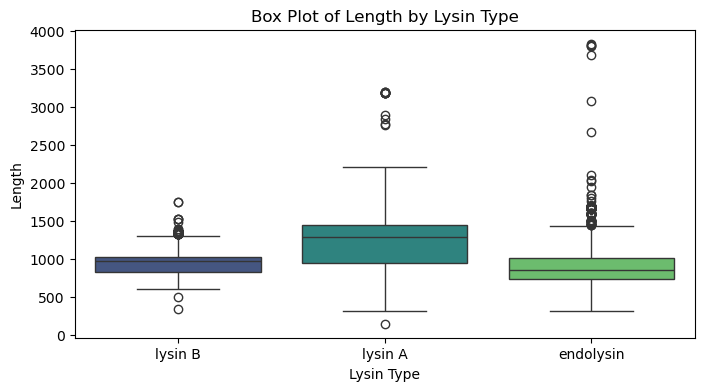

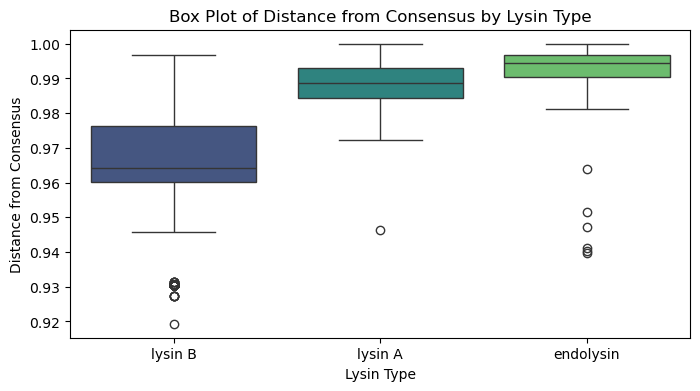

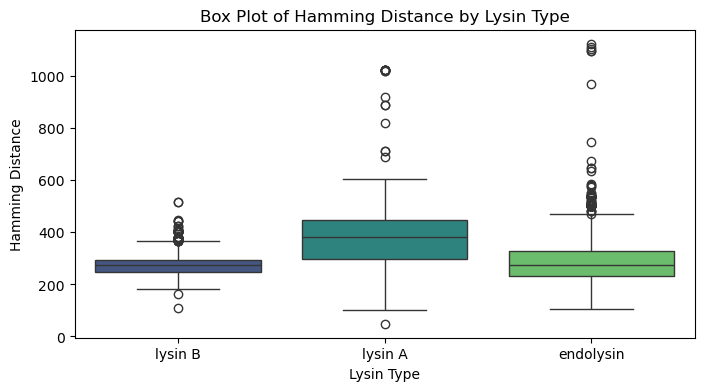

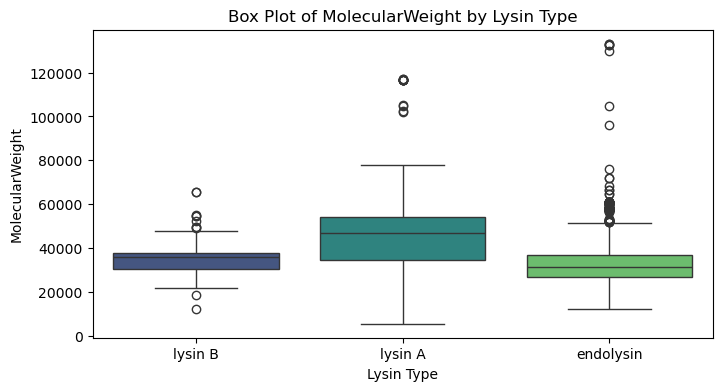

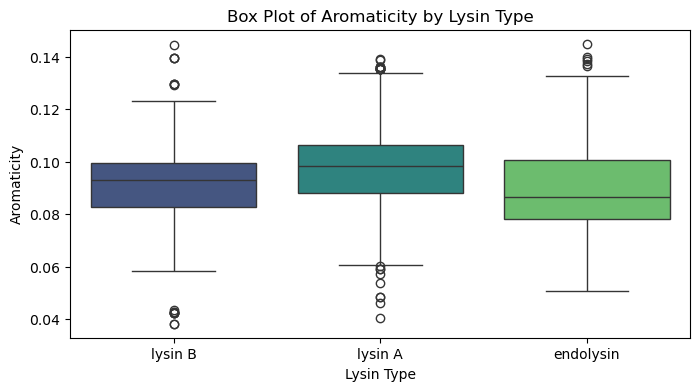

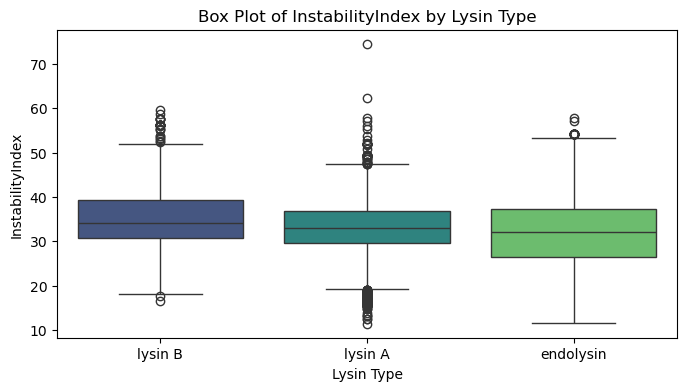

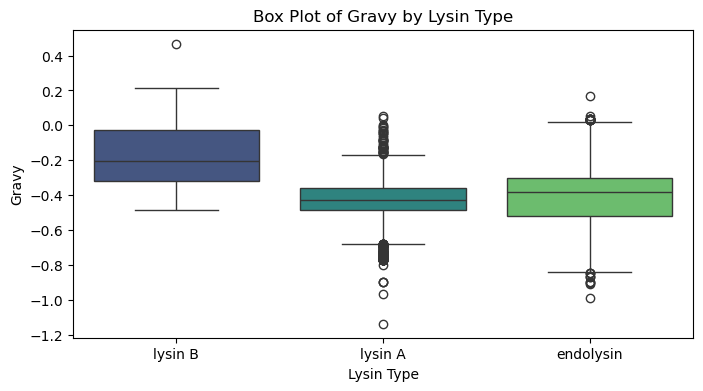

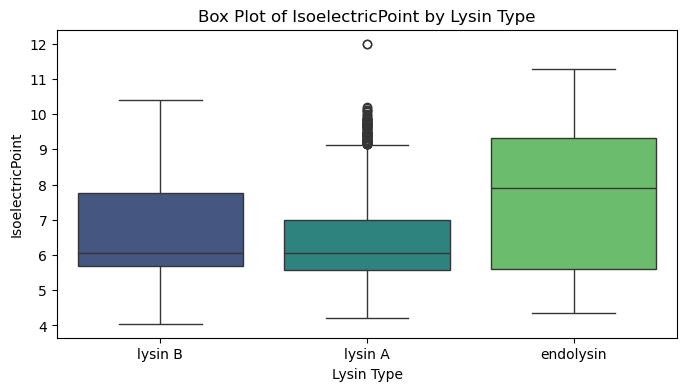

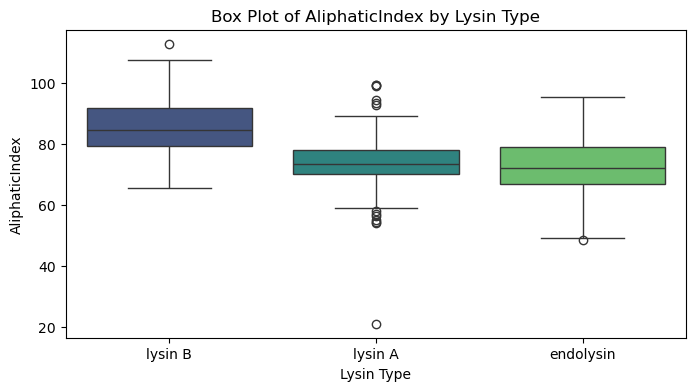

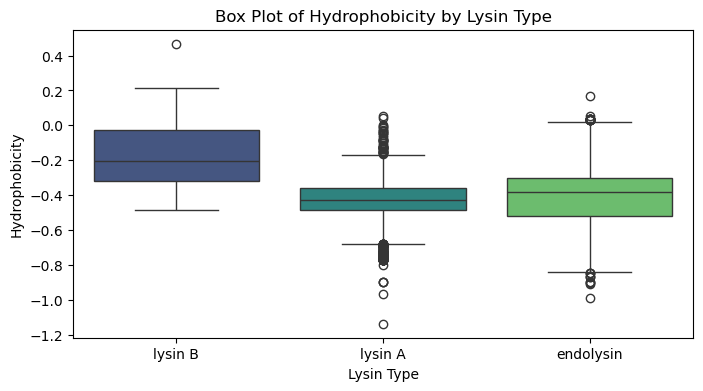

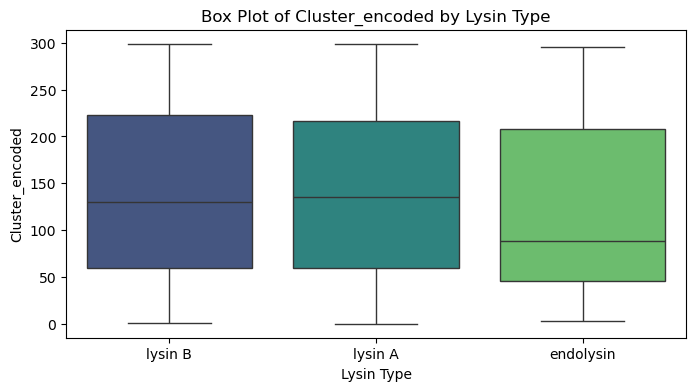

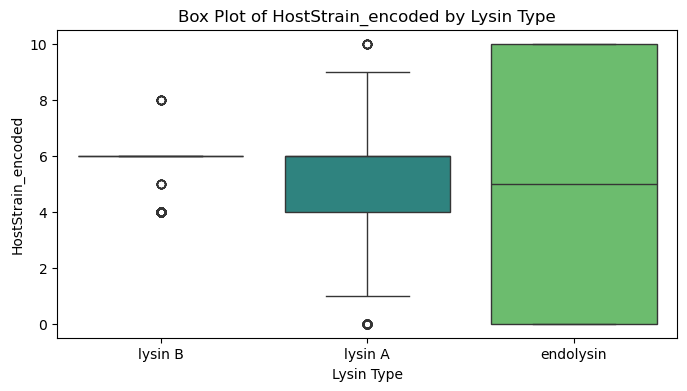

In [28]:
# Define a viridis palette for Lysin Types
unique_lysins = combined_df['LysinType'].unique()
viridis_palette = sns.color_palette("viridis", len(unique_lysins))

# Map the palette to the LysinType values
palette_dict = dict(zip(unique_lysins, viridis_palette))

# Create box plots for each feature, separated by LysinType
for feature in key_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='LysinType', y=feature, data=combined_df, hue='LysinType', palette=palette_dict, legend=False)
    plt.title(f'Box Plot of {feature} by Lysin Type')
    plt.xlabel('Lysin Type')
    plt.ylabel(feature)
    plt.show()

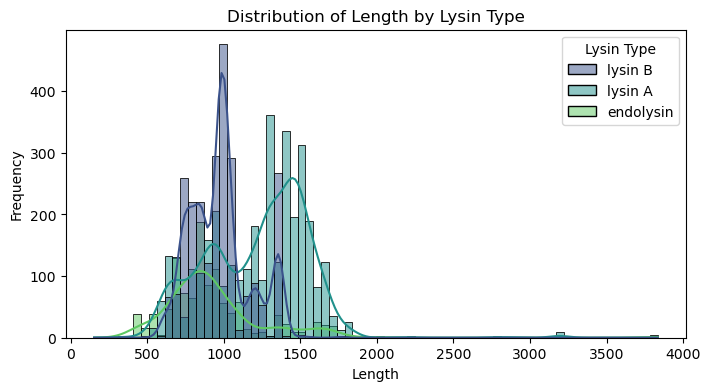

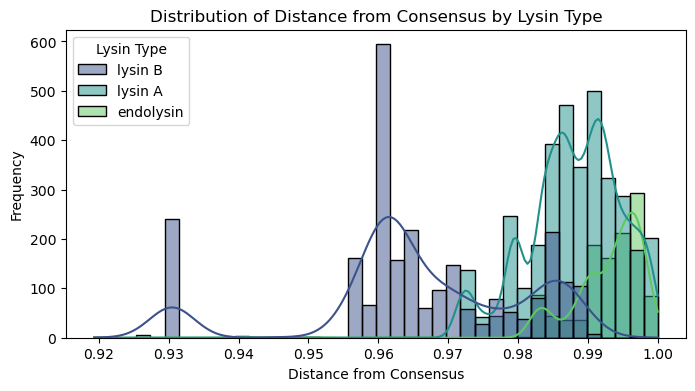

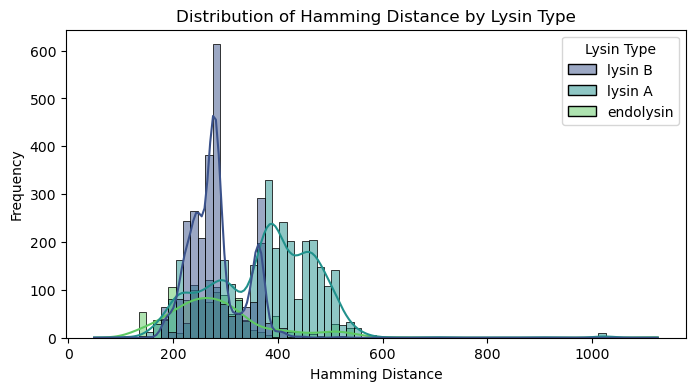

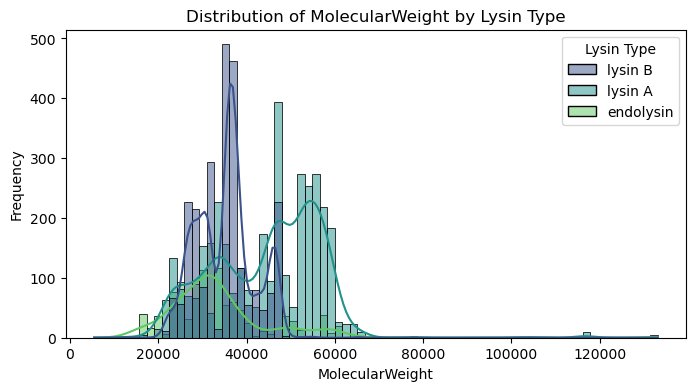

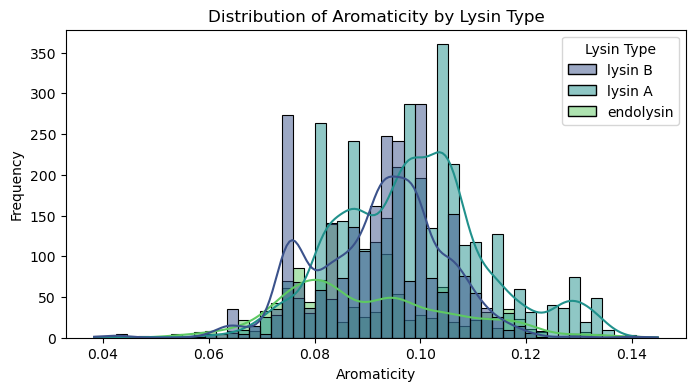

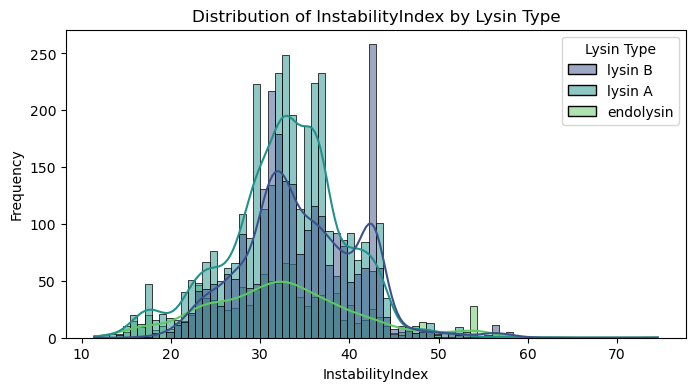

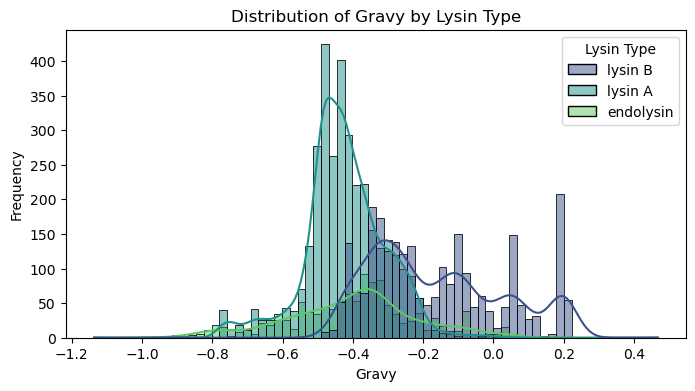

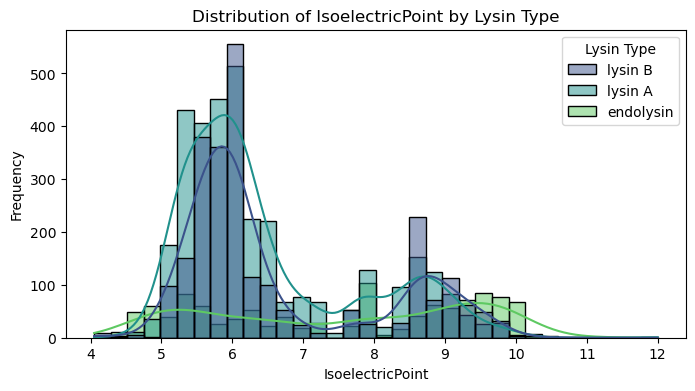

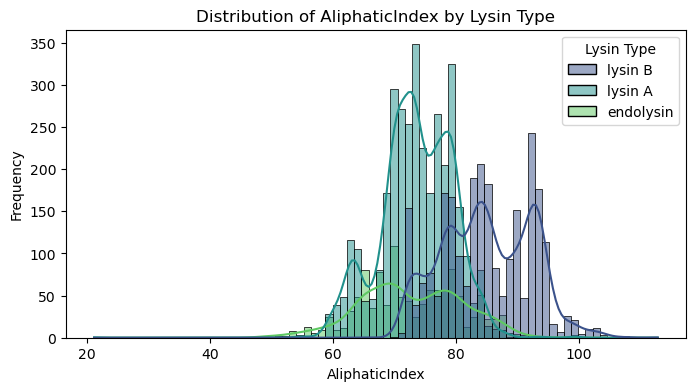

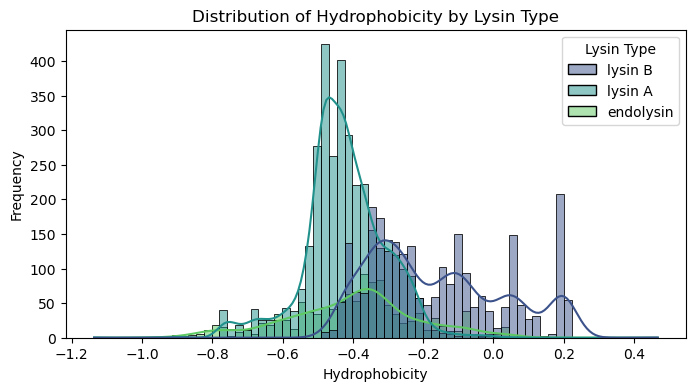

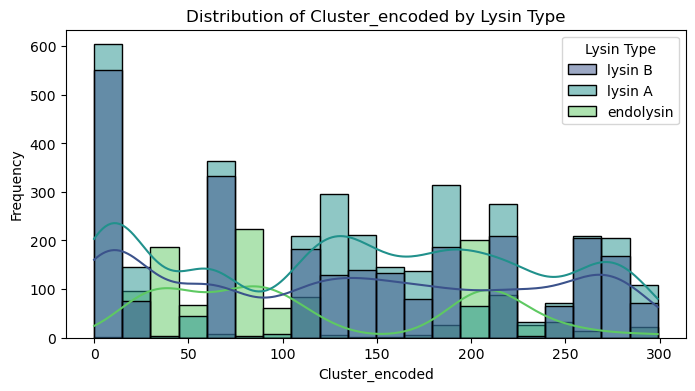

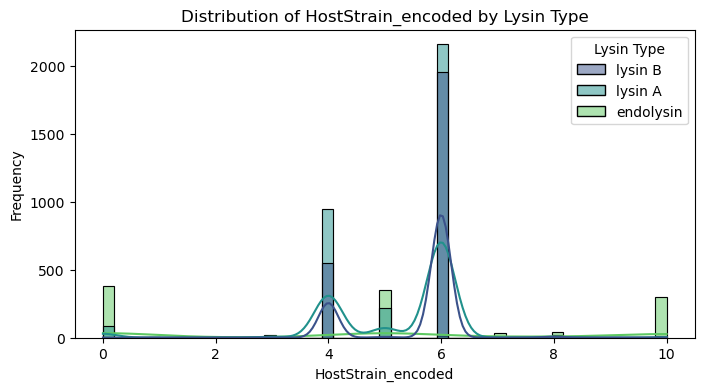

In [29]:
# Create histograms for each feature, separated by LysinType
for feature in key_features:
    plt.figure(figsize=(8, 4))
    plot = sns.histplot(data=combined_df, x=feature, hue='LysinType', kde=True, palette='viridis')
    plt.title(f'Distribution of {feature} by Lysin Type')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    
    # Ensure legend is displayed
    if len(plot.get_legend().get_texts()) > 0:
        plot.legend_.set_title('Lysin Type')
    else:
        plt.legend(title='Lysin Type')
    
    plt.show()

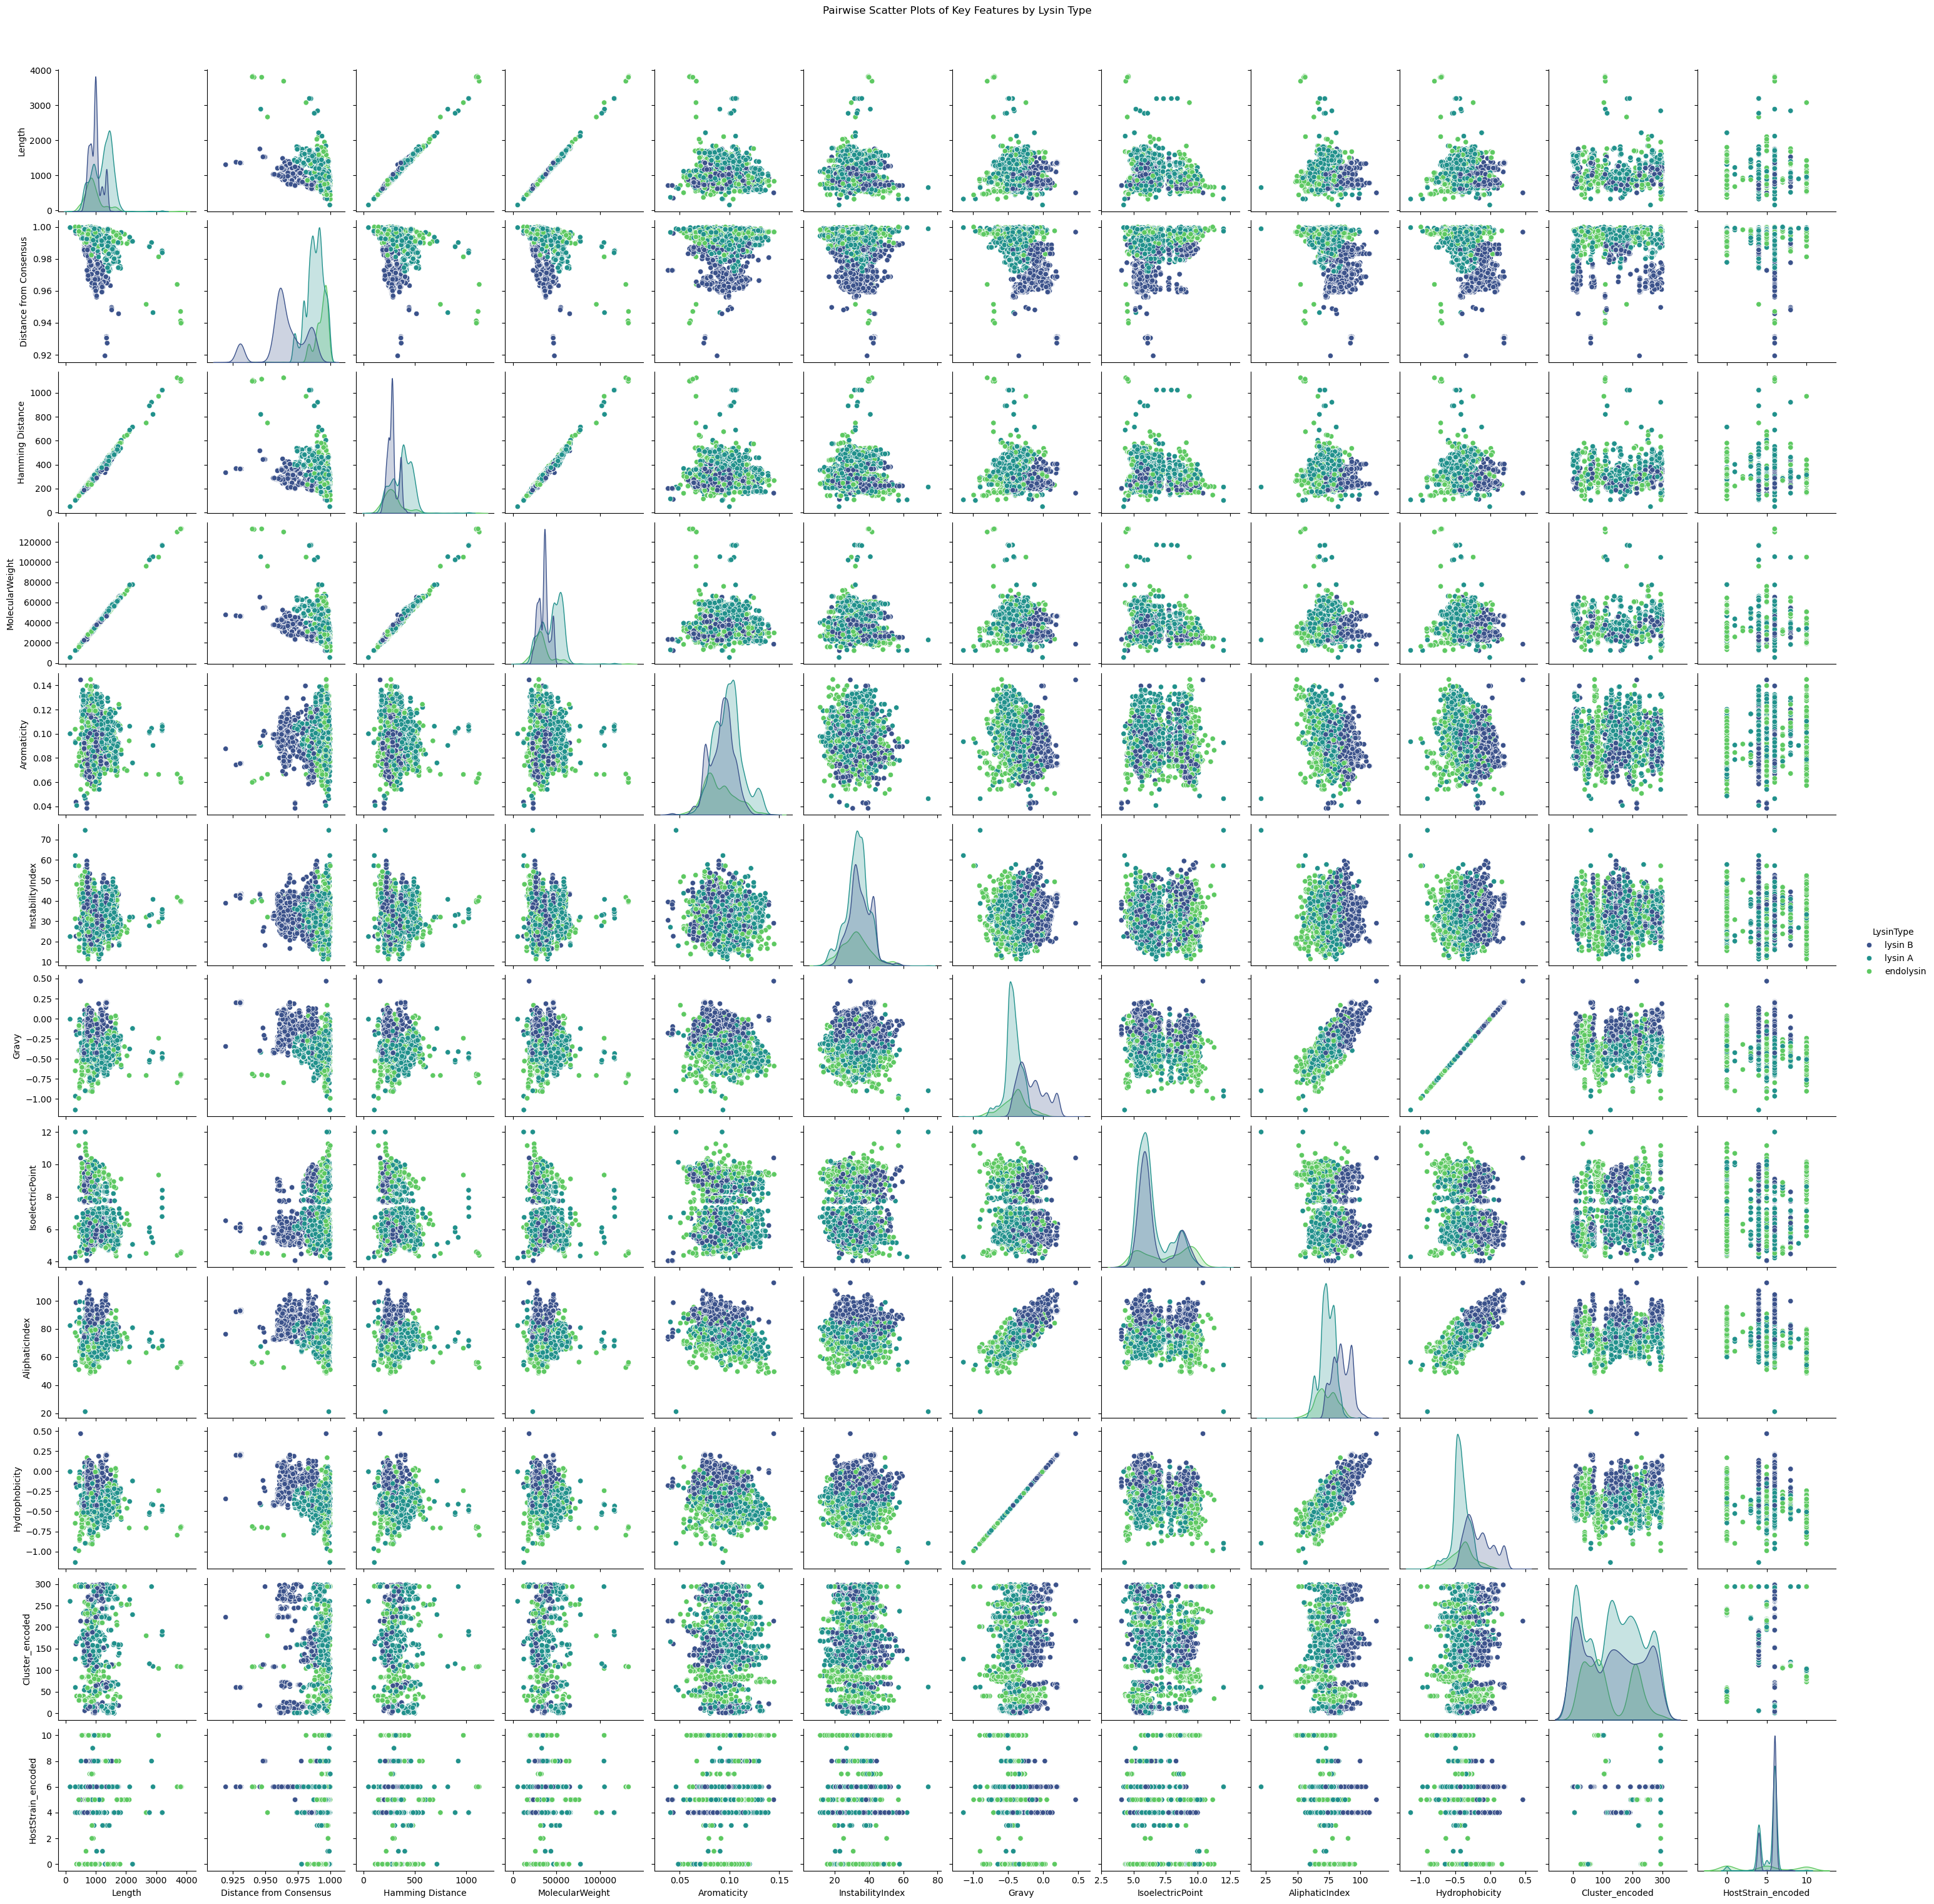

In [30]:
sns.pairplot(combined_df, vars=key_features, hue='LysinType', palette='viridis')
plt.suptitle('Pairwise Scatter Plots of Key Features by Lysin Type', y=1.02)
plt.show()

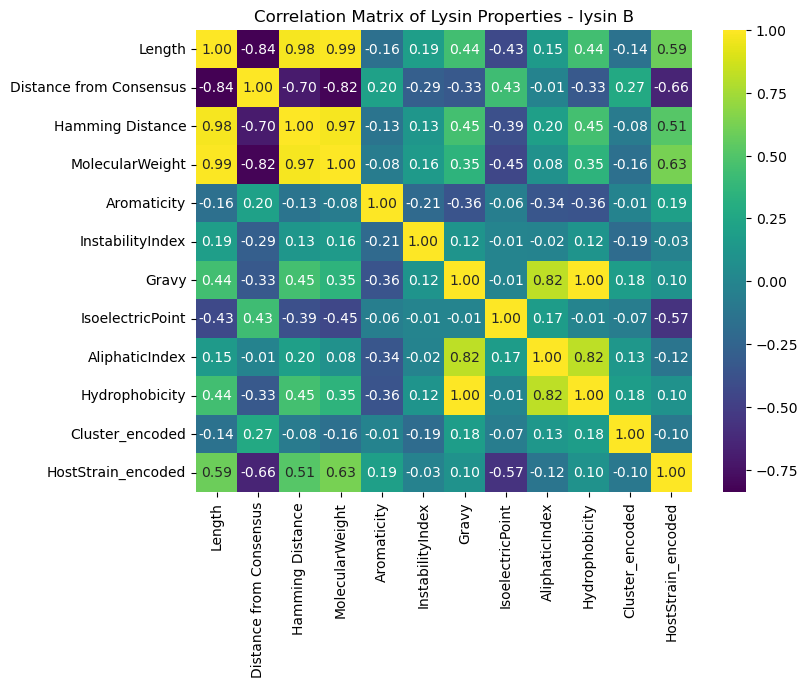

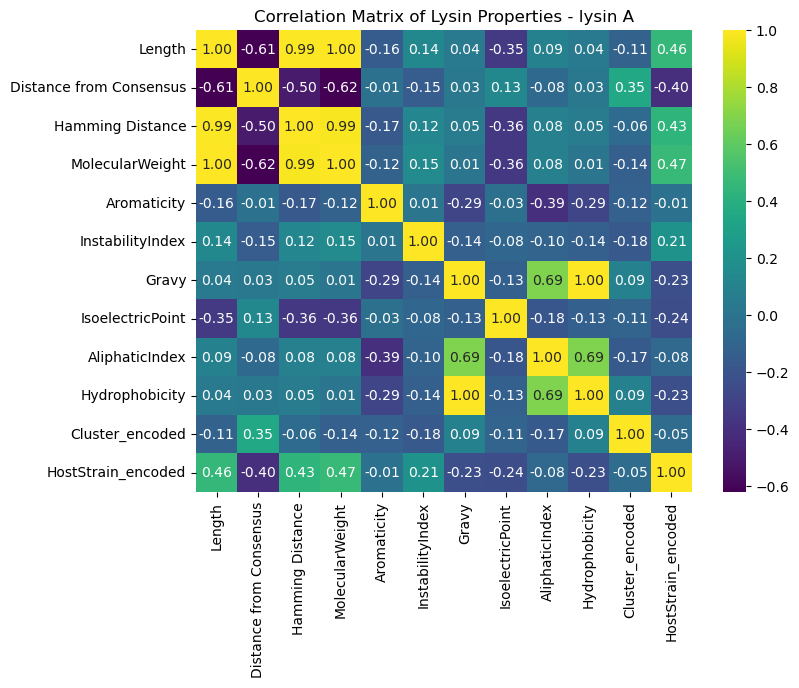

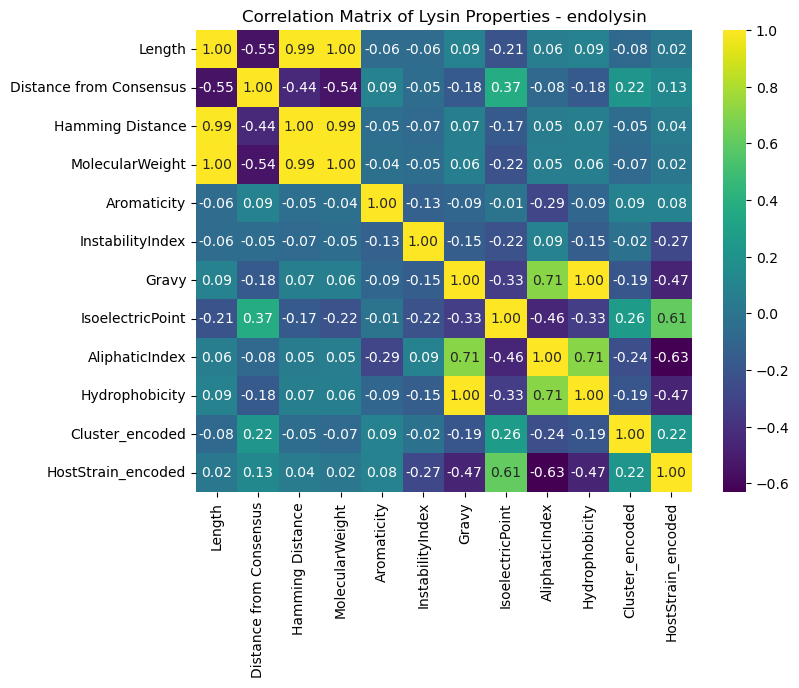

Table of Highly Correlated Features:
                  Feature 1         Feature 2  Correlation  LysinType
0   Distance from Consensus            Length    -0.837359    lysin B
1          Hamming Distance            Length     0.977369    lysin B
2                    Length   MolecularWeight     0.991231    lysin B
3   Distance from Consensus  Hamming Distance    -0.702769    lysin B
4   Distance from Consensus   MolecularWeight    -0.818890    lysin B
5          Hamming Distance   MolecularWeight     0.973104    lysin B
6            AliphaticIndex             Gravy     0.820098    lysin B
7                     Gravy    Hydrophobicity     1.000000    lysin B
8            AliphaticIndex    Hydrophobicity     0.820098    lysin B
9          Hamming Distance            Length     0.990640    lysin A
10                   Length   MolecularWeight     0.997647    lysin A
11         Hamming Distance   MolecularWeight     0.987132    lysin A
12                    Gravy    Hydrophobicity     1.0

In [31]:
# List of key features for analysis including encoded categorical features
key_features = [
    'Length', 'Distance from Consensus', 'Hamming Distance', 'MolecularWeight',
    'Aromaticity', 'InstabilityIndex', 'Gravy', 'IsoelectricPoint', 
    'AliphaticIndex', 'Hydrophobicity', 'Cluster_encoded', 'HostStrain_encoded'
]

# Function to plot the correlation heatmap and identify highly correlated features for a given LysinType
def plot_correlation_heatmap(df, lysin_type):
    correlation_matrix = df[key_features].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
    plt.title(f'Correlation Matrix of Lysin Properties - {lysin_type}')
    plt.show()
    
    # Identify pairs of highly correlated features (threshold > 0.7 or < -0.7)
    high_corr_pairs = correlation_matrix[(correlation_matrix > 0.7) | (correlation_matrix < -0.7)]
    high_corr_pairs = high_corr_pairs.stack().reset_index()
    high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]
    high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
    high_corr_pairs = high_corr_pairs[abs(high_corr_pairs['Correlation']) > 0.7]
    
    # Sort feature pairs to avoid duplicates
    high_corr_pairs[['Feature 1', 'Feature 2']] = np.sort(high_corr_pairs[['Feature 1', 'Feature 2']], axis=1)
    
    # Drop duplicate pairs
    high_corr_pairs = high_corr_pairs.drop_duplicates(subset=['Feature 1', 'Feature 2'])
    
    high_corr_pairs['LysinType'] = lysin_type
    return high_corr_pairs

# Combine results for all LysinTypes
all_high_corr_pairs = pd.DataFrame()

# Filter data for each LysinType and plot the heatmap and store highly correlated features
for lysin_type in combined_df['LysinType'].unique():
    lysin_type_df = combined_df[combined_df['LysinType'] == lysin_type]
    high_corr_pairs = plot_correlation_heatmap(lysin_type_df, lysin_type)
    all_high_corr_pairs = pd.concat([all_high_corr_pairs, high_corr_pairs], ignore_index=True)

# Drop duplicate feature pairs across all LysinTypes
all_high_corr_pairs[['Feature 1', 'Feature 2']] = np.sort(all_high_corr_pairs[['Feature 1', 'Feature 2']], axis=1)
all_high_corr_pairs = all_high_corr_pairs.drop_duplicates(subset=['Feature 1', 'Feature 2', 'LysinType'])

# Display the table of highly correlated features
all_high_corr_pairs.reset_index(drop=True, inplace=True)
print("Table of Highly Correlated Features:")
print(all_high_corr_pairs)


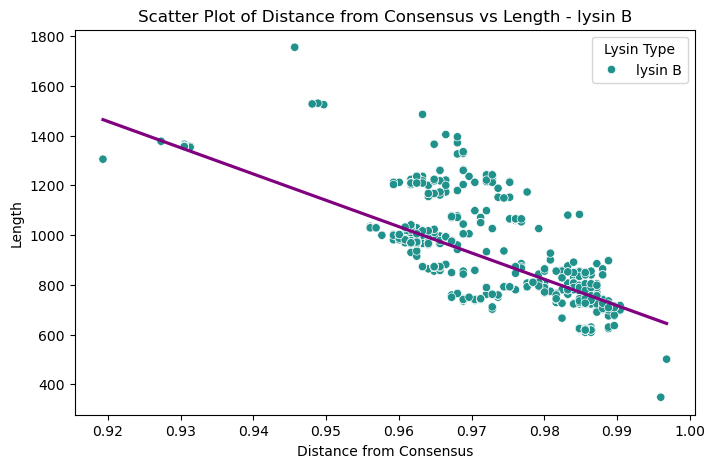

Pearson correlation coefficient between Distance from Consensus and Length for lysin B: -0.8373588758250423, P-value: 0.0


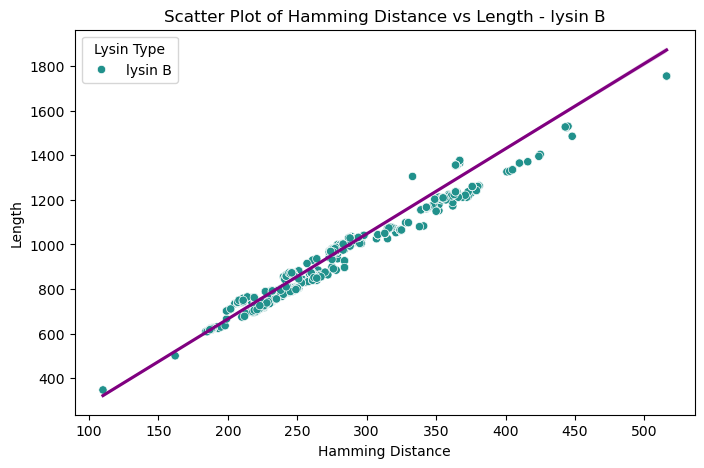

Pearson correlation coefficient between Hamming Distance and Length for lysin B: 0.9773690114315916, P-value: 0.0


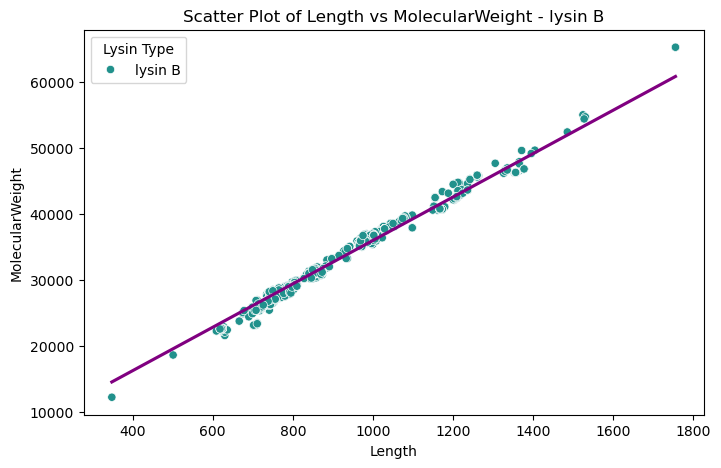

Pearson correlation coefficient between Length and MolecularWeight for lysin B: 0.9912308611181038, P-value: 0.0


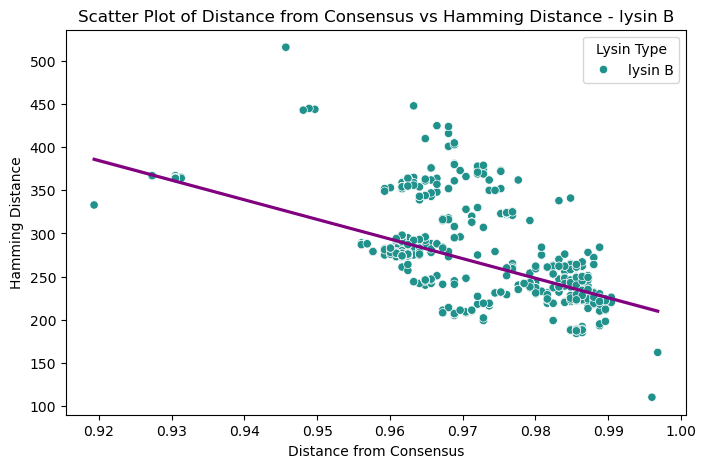

Pearson correlation coefficient between Distance from Consensus and Hamming Distance for lysin B: -0.7027686909434927, P-value: 0.0


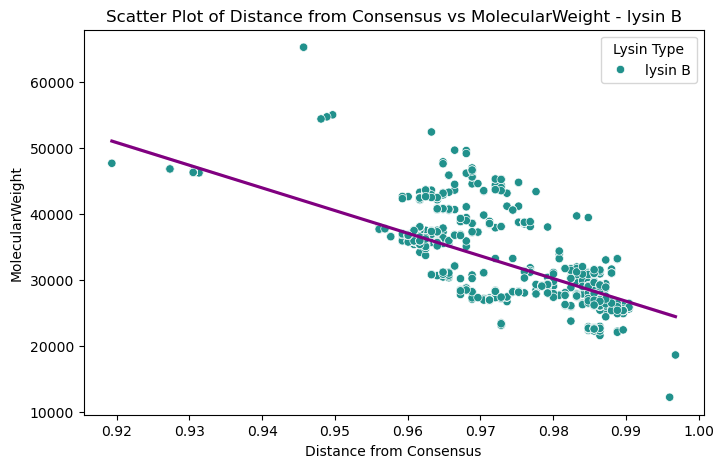

Pearson correlation coefficient between Distance from Consensus and MolecularWeight for lysin B: -0.8188904711694365, P-value: 0.0


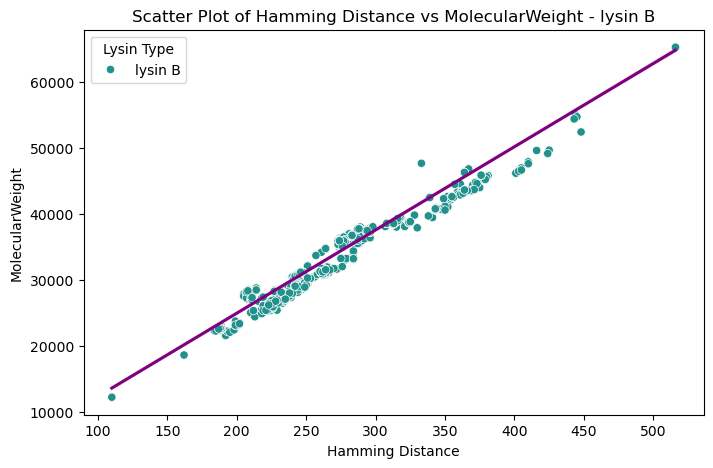

Pearson correlation coefficient between Hamming Distance and MolecularWeight for lysin B: 0.9731036180108972, P-value: 0.0


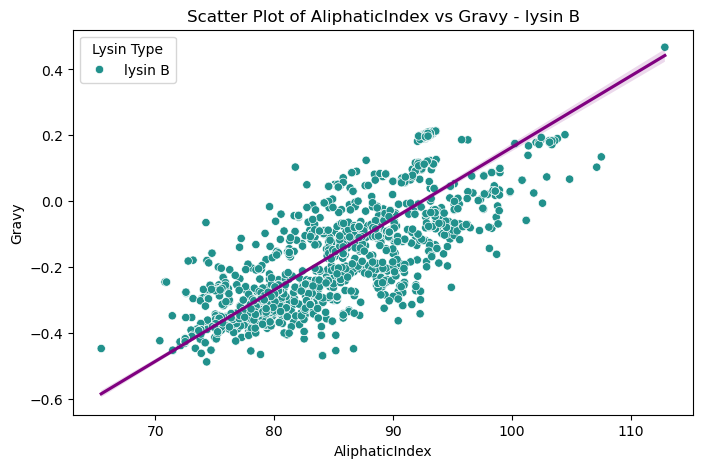

Pearson correlation coefficient between AliphaticIndex and Gravy for lysin B: 0.8200976261587396, P-value: 0.0


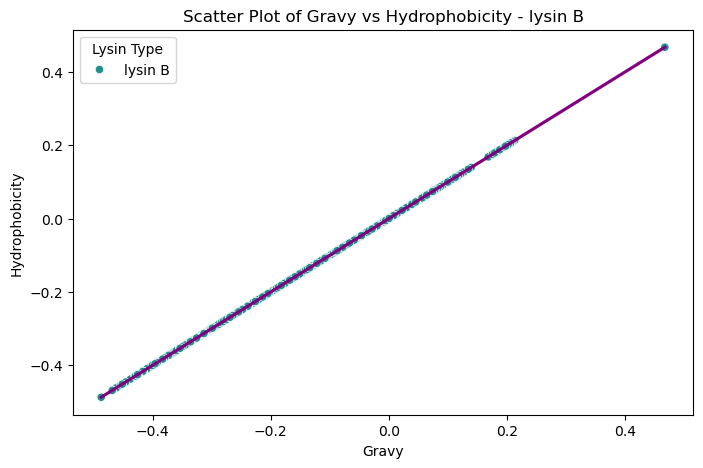

Pearson correlation coefficient between Gravy and Hydrophobicity for lysin B: 0.9999999999999999, P-value: 0.0


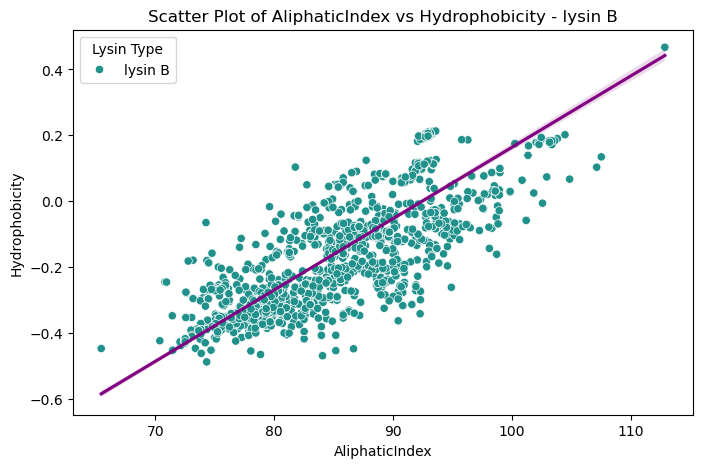

Pearson correlation coefficient between AliphaticIndex and Hydrophobicity for lysin B: 0.8200976261587396, P-value: 0.0




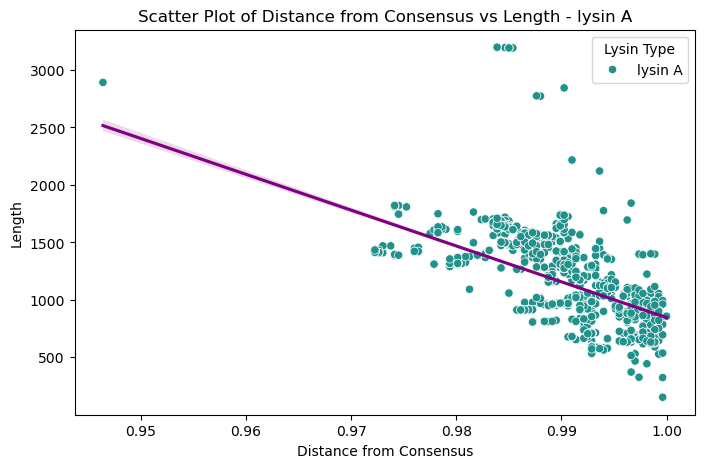

Pearson correlation coefficient between Distance from Consensus and Length for lysin A: -0.6140772093406651, P-value: 0.0


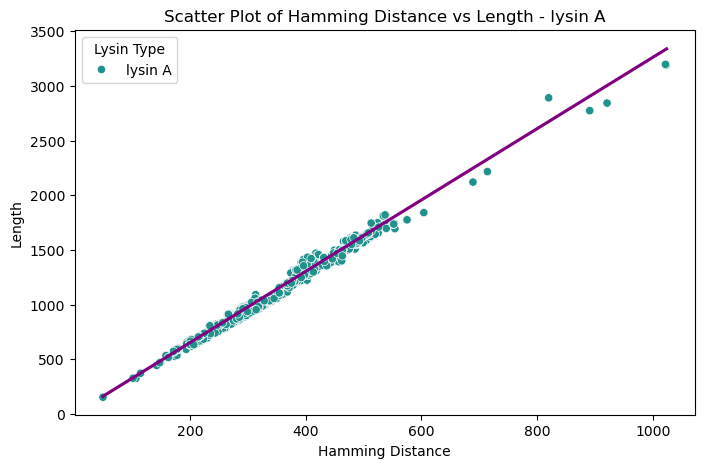

Pearson correlation coefficient between Hamming Distance and Length for lysin A: 0.9906402444807416, P-value: 0.0


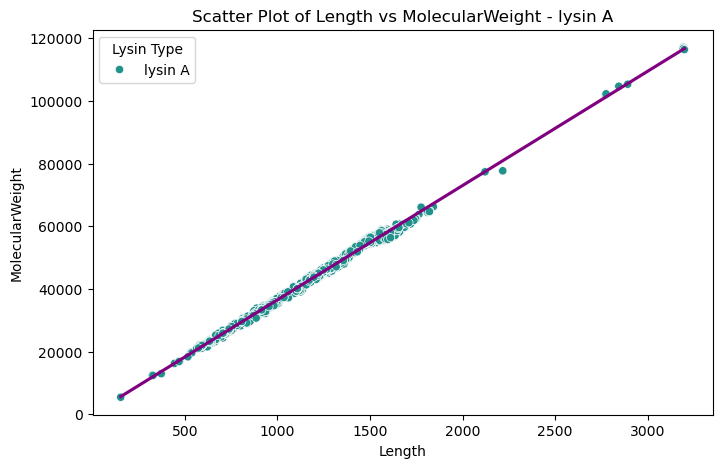

Pearson correlation coefficient between Length and MolecularWeight for lysin A: 0.9976466112707072, P-value: 0.0


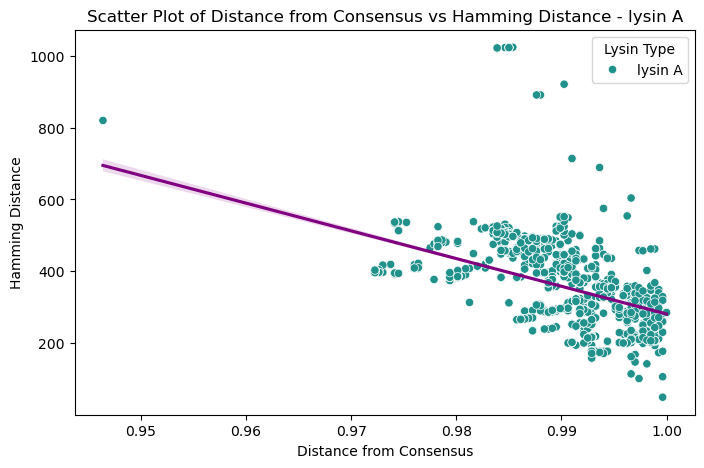

Pearson correlation coefficient between Distance from Consensus and Hamming Distance for lysin A: -0.5005985181010212, P-value: 8.692343738099946e-219


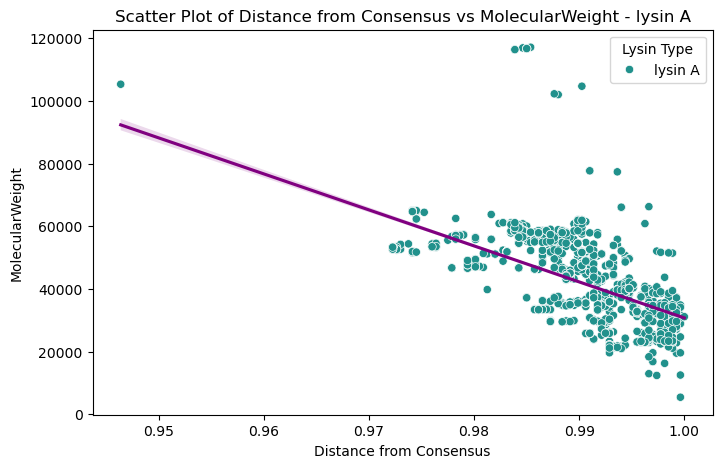

Pearson correlation coefficient between Distance from Consensus and MolecularWeight for lysin A: -0.6194389629257715, P-value: 0.0


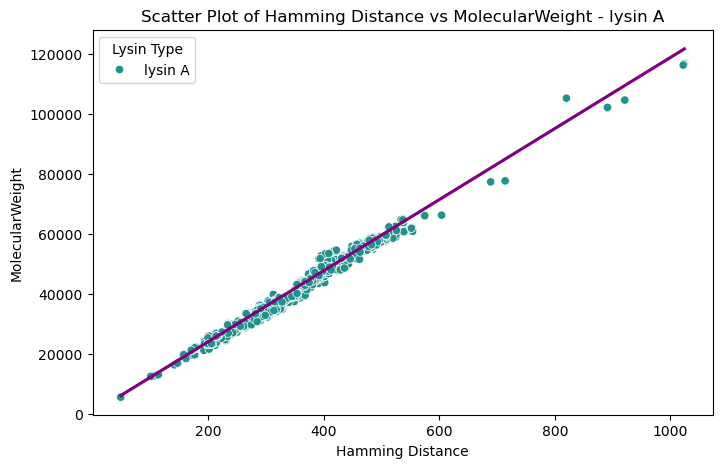

Pearson correlation coefficient between Hamming Distance and MolecularWeight for lysin A: 0.987131638406566, P-value: 0.0


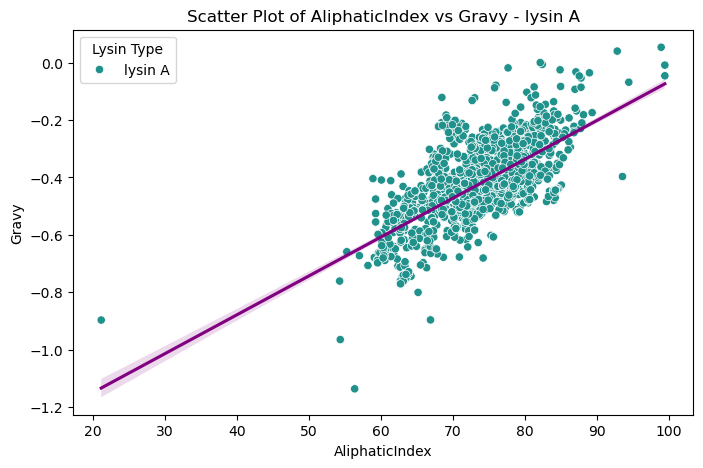

Pearson correlation coefficient between AliphaticIndex and Gravy for lysin A: 0.6859346498804424, P-value: 0.0


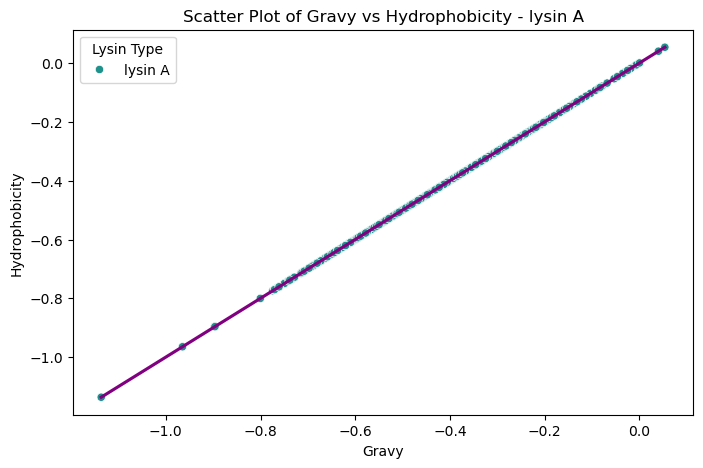

Pearson correlation coefficient between Gravy and Hydrophobicity for lysin A: 1.0, P-value: 0.0


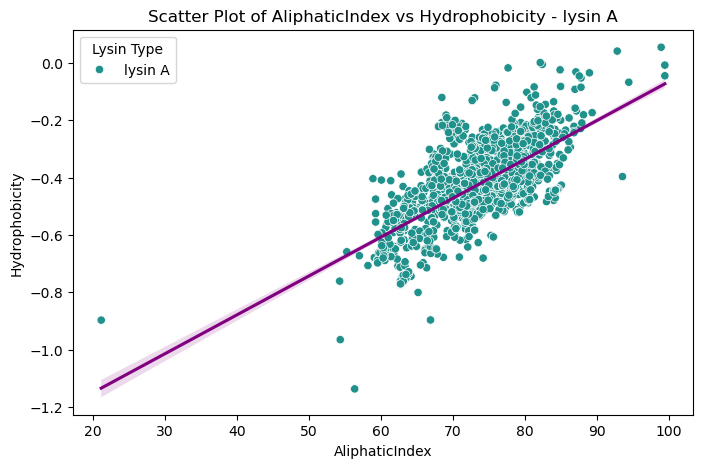

Pearson correlation coefficient between AliphaticIndex and Hydrophobicity for lysin A: 0.6859346498804423, P-value: 0.0




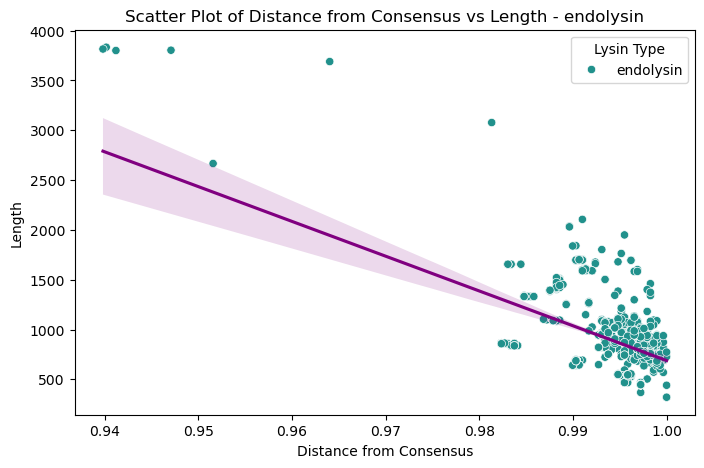

Pearson correlation coefficient between Distance from Consensus and Length for endolysin: -0.5480213197695323, P-value: 6.840539202327007e-91


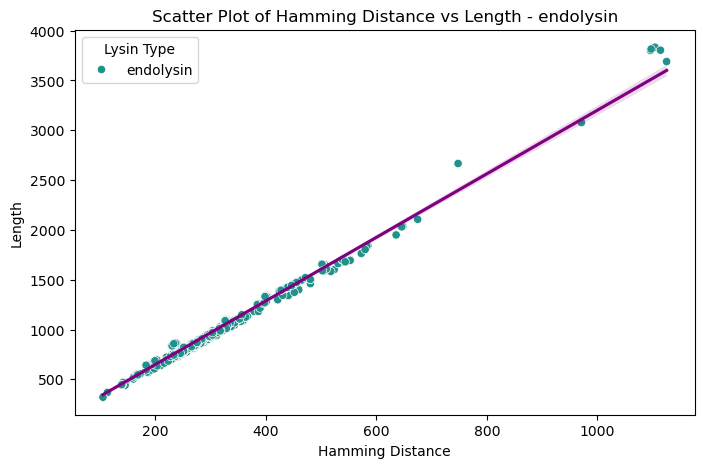

Pearson correlation coefficient between Hamming Distance and Length for endolysin: 0.9925153434180444, P-value: 0.0


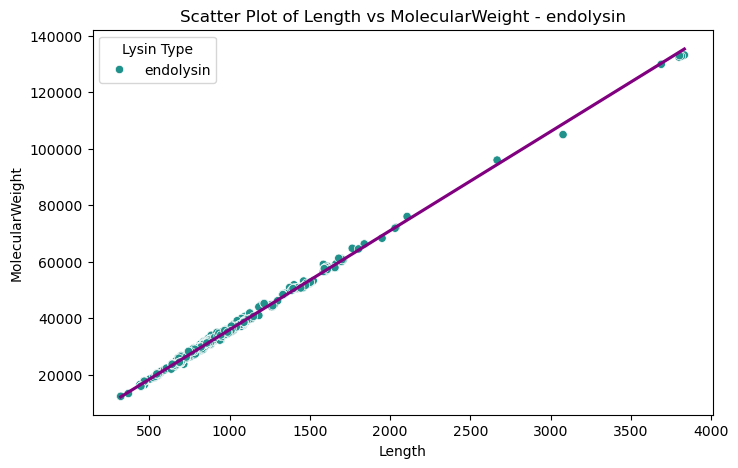

Pearson correlation coefficient between Length and MolecularWeight for endolysin: 0.998489935678343, P-value: 0.0


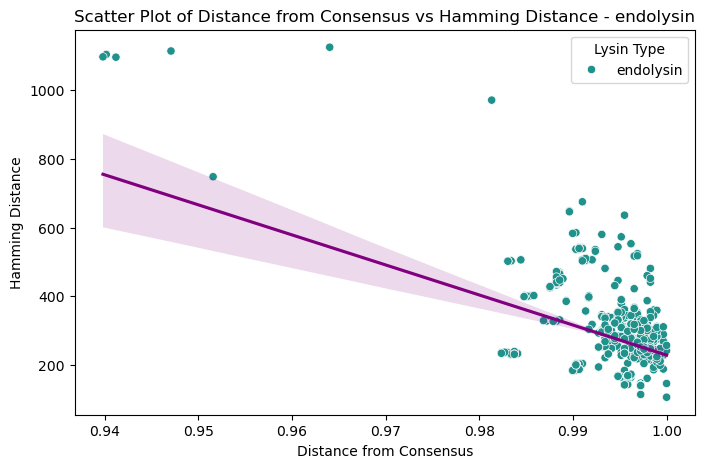

Pearson correlation coefficient between Distance from Consensus and Hamming Distance for endolysin: -0.4417705447202577, P-value: 5.54678939869325e-56


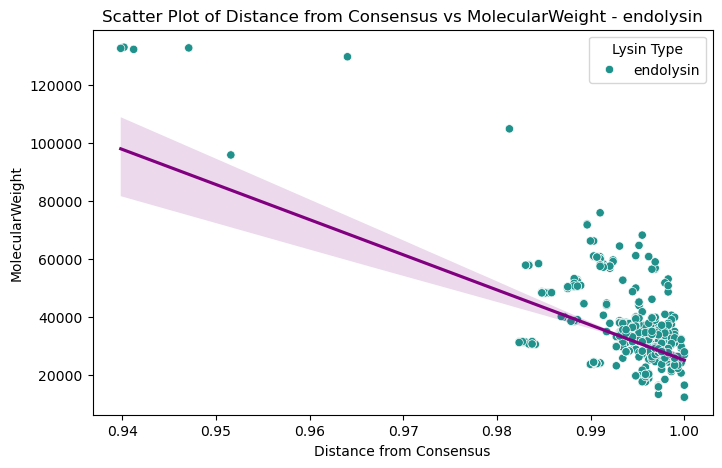

Pearson correlation coefficient between Distance from Consensus and MolecularWeight for endolysin: -0.5420711193931758, P-value: 1.3618420943622007e-88


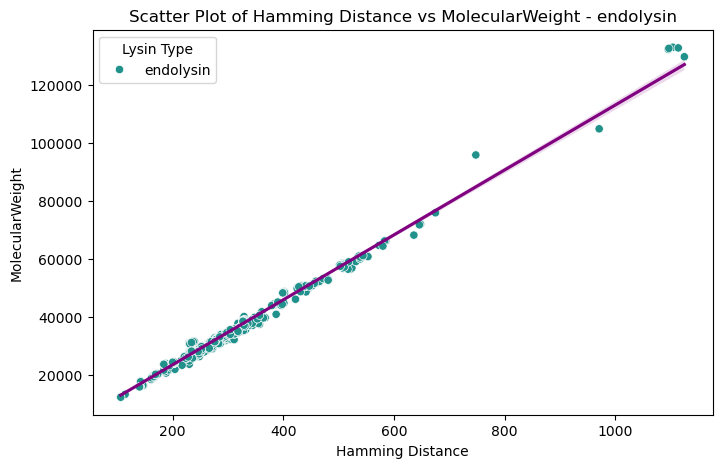

Pearson correlation coefficient between Hamming Distance and MolecularWeight for endolysin: 0.991764465449676, P-value: 0.0


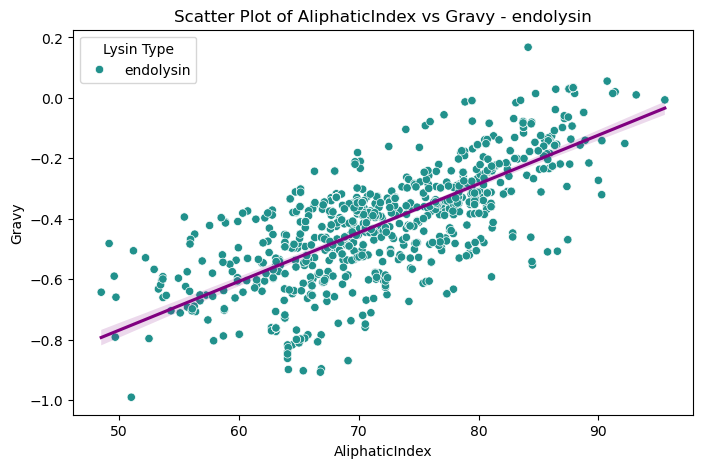

Pearson correlation coefficient between AliphaticIndex and Gravy for endolysin: 0.7122439826938045, P-value: 3.3671122152243815e-178


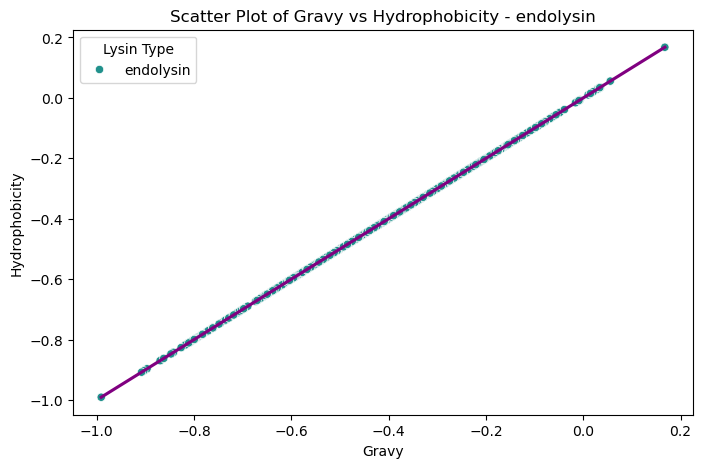

Pearson correlation coefficient between Gravy and Hydrophobicity for endolysin: 1.0, P-value: 0.0


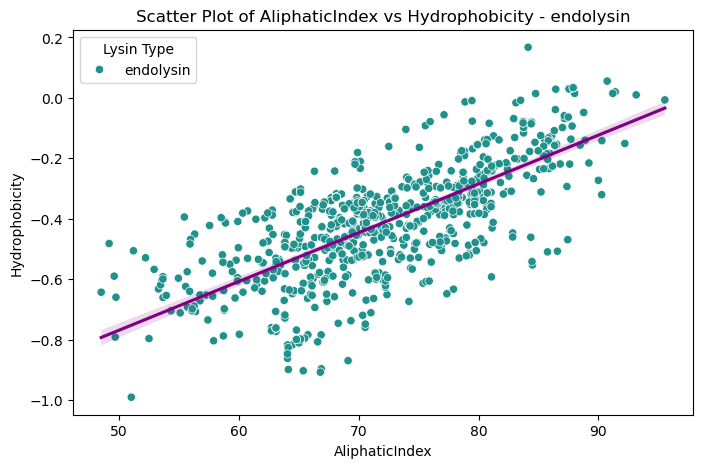

Pearson correlation coefficient between AliphaticIndex and Hydrophobicity for endolysin: 0.7122439826938045, P-value: 3.3671122152243815e-178


Table of Pearson Correlation Coefficients and P-values:
    LysinType                Feature 1         Feature 2  Pearson Correlation  \
0     lysin B  Distance from Consensus            Length            -0.837359   
1     lysin B         Hamming Distance            Length             0.977369   
2     lysin B                   Length   MolecularWeight             0.991231   
3     lysin B  Distance from Consensus  Hamming Distance            -0.702769   
4     lysin B  Distance from Consensus   MolecularWeight            -0.818890   
5     lysin B         Hamming Distance   MolecularWeight             0.973104   
6     lysin B           AliphaticIndex             Gravy             0.820098   
7     lysin B                    Gravy    Hydrophobicity             1.000000   
8     lysin B           AliphaticIndex    Hydrophobicity             0.

In [32]:
# Highly correlated pairs from the table
high_corr_pairs = [
    ('Distance from Consensus', 'Length'),
    ('Hamming Distance', 'Length'),
    ('Length', 'MolecularWeight'),
    ('Distance from Consensus', 'Hamming Distance'),
    ('Distance from Consensus', 'MolecularWeight'),
    ('Hamming Distance', 'MolecularWeight'),
    ('AliphaticIndex', 'Gravy'),
    ('Gravy', 'Hydrophobicity'),
    ('AliphaticIndex', 'Hydrophobicity')
]

# Create scatter plots with regression lines
def plot_scatter_with_regression(df, feature1, feature2, lysin_type):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=feature1, y=feature2, hue='LysinType', data=df, palette='viridis')
    sns.regplot(x=feature1, y=feature2, data=df, scatter=False, color='purple')
    plt.title(f'Scatter Plot of {feature1} vs {feature2} - {lysin_type}')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend(title='Lysin Type')
    plt.show()

# Calculate Pearson correlation coefficients
def calculate_pearson_correlation(df, feature1, feature2):
    correlation, p_value = pearsonr(df[feature1], df[feature2])
    return correlation, p_value

# Initialize a list to store the results
pearson_results_list = []

# Explore and generate statistics for each LysinType
for lysin_type in combined_df['LysinType'].unique():
    lysin_type_df = combined_df[combined_df['LysinType'] == lysin_type]
    
    # Plot scatter plots with regression lines and calculate Pearson correlations
    for feature1, feature2 in high_corr_pairs:
        plot_scatter_with_regression(lysin_type_df, feature1, feature2, lysin_type)
        correlation, p_value = calculate_pearson_correlation(lysin_type_df, feature1, feature2)
        print(f"Pearson correlation coefficient between {feature1} and {feature2} for {lysin_type}: {correlation}, P-value: {p_value}")
        
        # Store the results in the list
        pearson_results_list.append({
            'LysinType': lysin_type,
            'Feature 1': feature1,
            'Feature 2': feature2,
            'Pearson Correlation': correlation,
            'P-value': p_value
        })

    print("\n")

# Convert the list to a DataFrame
pearson_results = pd.DataFrame(pearson_results_list)

# Display the table of Pearson correlation coefficients and p-values
print("Table of Pearson Correlation Coefficients and P-values:")
print(pearson_results)


In [34]:
# Save DataFrame to JSON file
combined_df.to_json('lysin_combined_df.json', orient='records', lines=True)